In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

from collections import Counter
from collections import defaultdict

import sys


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a futur

In [3]:
# Funzione che viene chiamata sul:
# - y_true: target reale
# - y_pred: target predetto dal classificatore
# stampa: matrice di confusione, accuracy, precision, recall, specificity, F1
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [4]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [5]:
sys.path.append('./lore/')

In [6]:
from util import record2str, neuclidean
from datamanager import prepare_adult_dataset, prepare_dataset

In [202]:
# Dataset con attributi originali
df = pd.read_csv("../dataset_All_normalized.csv")
dataframe = pd.read_csv("dataset_explanability.csv")
class_name = 'Occupancy'

In [203]:
df

Temperature     Light       CO2  HumidityRatio  Day  Afternoon  \
0         0.869029  0.603964  0.208231       0.549737    0          1   
1         0.872357  0.596946  0.215163       0.551972    0          1   
2         0.874576  0.591029  0.220898       0.549997    0          1   
3         0.873190  0.509582  0.224045       0.544374    0          1   
4         0.879014  0.504267  0.226675       0.550376    0          1   
...            ...       ...       ...            ...  ...        ...   
20555     0.335593  0.443530  0.676157       0.404757    1          0   
20556     0.344838  0.437080  0.681881       0.409306    1          0   
20557     0.349461  0.437080  0.686214       0.411030    1          0   
20558     0.349461  0.432177  0.754603       0.422253    1          0   
20559     0.369800  0.422115  0.898190       0.433102    1          0   

       Evening  Night  Weekday  Weekend  Occupancy  
0            0      0        1        0          1  
1            0      0        1        0          1  
2            0      0        1        0          1  
3            0      0        1        0          1  
4            0      0        1        0          1  
...        ...    ...      ...      ...        ...  
20555        0      0        1        0          1  
20556        0      0        1        0          1  
20557        0      0        1        0          1  
20558        0      0        1        0          1  
20559        0      0        1        0          1  

[20560 rows x 11 columns]

In [204]:
dataframe

Temperature     Light       CO2  HumidityRatio TimeSpan WeekSpan  \
0         0.869029  0.603964  0.208231       0.549737       AF       WD   
1         0.872357  0.596946  0.215163       0.551972       AF       WD   
2         0.874576  0.591029  0.220898       0.549997       AF       WD   
3         0.873190  0.509582  0.224045       0.544374       AF       WD   
4         0.879014  0.504267  0.226675       0.550376       AF       WD   
...            ...       ...       ...            ...      ...      ...   
20555     0.335593  0.443530  0.676157       0.404757       DA       WD   
20556     0.344838  0.437080  0.681881       0.409306       DA       WD   
20557     0.349461  0.437080  0.686214       0.411030       DA       WD   
20558     0.349461  0.432177  0.754603       0.422253       DA       WD   
20559     0.369800  0.422115  0.898190       0.433102       DA       WD   

       Occupancy  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
20555          1  
20556          1  
20557          1  
20558          1  
20559          1  

[20560 rows x 7 columns]

In [205]:
res = prepare_dataset(dataframe, class_name)
df1, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res


In [206]:
rdf

Temperature     Light       CO2  HumidityRatio TimeSpan WeekSpan  \
0         0.869029  0.603964  0.208231       0.549737       AF       WD   
1         0.872357  0.596946  0.215163       0.551972       AF       WD   
2         0.874576  0.591029  0.220898       0.549997       AF       WD   
3         0.873190  0.509582  0.224045       0.544374       AF       WD   
4         0.879014  0.504267  0.226675       0.550376       AF       WD   
...            ...       ...       ...            ...      ...      ...   
20555     0.335593  0.443530  0.676157       0.404757       DA       WD   
20556     0.344838  0.437080  0.681881       0.409306       DA       WD   
20557     0.349461  0.437080  0.686214       0.411030       DA       WD   
20558     0.349461  0.432177  0.754603       0.422253       DA       WD   
20559     0.369800  0.422115  0.898190       0.433102       DA       WD   

       Occupancy  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
20555          1  
20556          1  
20557          1  
20558          1  
20559          1  

[20560 rows x 7 columns]

In [207]:
df1

Temperature     Light       CO2  HumidityRatio  TimeSpan=AF  \
0         0.869029  0.603964  0.208231       0.549737            1   
1         0.872357  0.596946  0.215163       0.551972            1   
2         0.874576  0.591029  0.220898       0.549997            1   
3         0.873190  0.509582  0.224045       0.544374            1   
4         0.879014  0.504267  0.226675       0.550376            1   
...            ...       ...       ...            ...          ...   
20555     0.335593  0.443530  0.676157       0.404757            0   
20556     0.344838  0.437080  0.681881       0.409306            0   
20557     0.349461  0.437080  0.686214       0.411030            0   
20558     0.349461  0.432177  0.754603       0.422253            0   
20559     0.369800  0.422115  0.898190       0.433102            0   

       TimeSpan=DA  TimeSpan=EV  TimeSpan=NI  WeekSpan=WD  WeekSpan=WE  \
0                0            0            0            1            0   
1                0            0            0            1            0   
2                0            0            0            1            0   
3                0            0            0            1            0   
4                0            0            0            1            0   
...            ...          ...          ...          ...          ...   
20555            1            0            0            1            0   
20556            1            0            0            1            0   
20557            1            0            0            1            0   
20558            1            0            0            1            0   
20559            1            0            0            1            0   

       Occupancy  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
20555          1  
20556          1  
20557          1  
20558          1  
20559          1  

[20560 rows x 11 columns]

In [208]:
test_size = 0.3
random_state = 1000

X_train, X_test, y_train, y_test = train_test_split(df1[feature_names].values, df1[class_name].values, 
                                                    test_size=test_size,
                                                    random_state=random_state, 
                                                    stratify=df1[class_name].values)

_, K, _, _ = train_test_split(rdf[real_feature_names].values, rdf[class_name].values, 
                              test_size=test_size,
                              random_state=random_state, 
                              stratify=df[class_name].values)

# Classification - Non Linear SVM

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [184]:
bb = SVC(gamma=1.0, C=1.0, kernel='poly', probability= True)
bb.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [185]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [186]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred))

Accuracy 0.990
F1-measure 0.979


**** Matrice di Confusione *****
 True negative: 4682 False negative: 0
 True positive: 1425 False positive: 61
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9901
Numero di campioni correttamente correlati:  6107
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9590
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9871
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9790
____________________________________________
              precision    recall  f1-score   

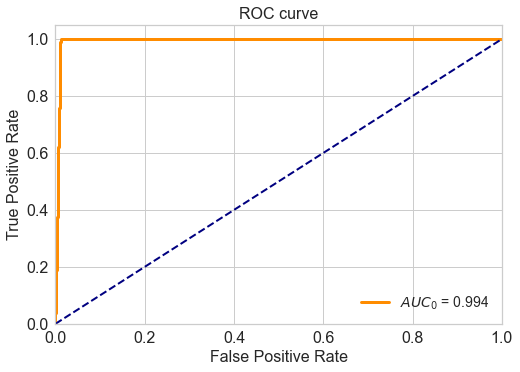

____________________________________
****** VALORE DI AUC *******
0.9942035354039748
____________________________________
****** ROC CURVE: con metodo diretto *******


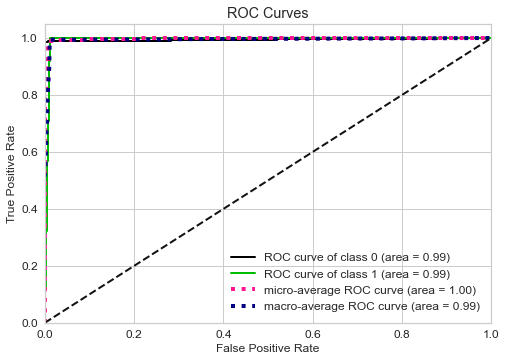

____________________________________
****** Precision recall: con metodo diretto *******


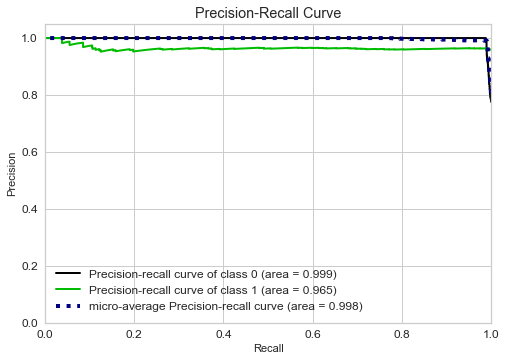

____________________________________
****** Cumulative gain: con metodo diretto *******


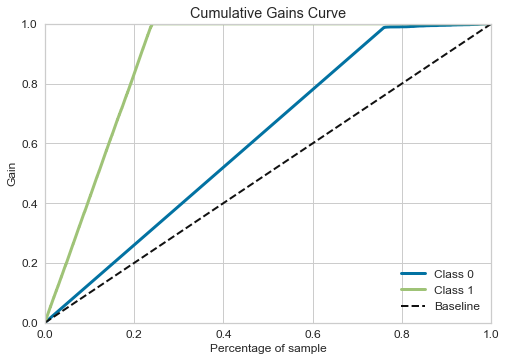

____________________________________
****** Lift curve: con metodo diretto *******


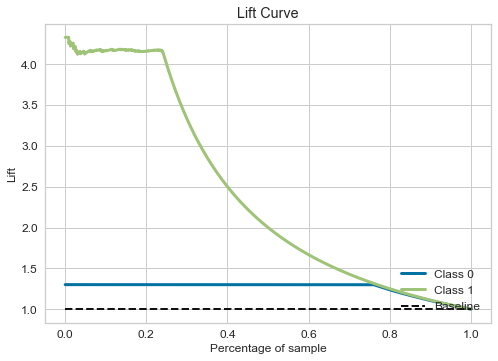

In [187]:
result_pred(y_test, y_pred)
y_score = bb.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

### Explanation - Global Explanation
### Partial Explanation Plot

In [89]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

from skater.core.global_interpretation.partial_dependence import PartialDependence

In [90]:
interpreter = Interpretation(X_train, feature_names=feature_names)

2020-06-10 21:17:23,811 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 21:17:25,504 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[28/28] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 21:17:26,785 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 21:17:28,483 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[12/12] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 21:17:29,406 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 21:17:31,707 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 3 seconds

2020-06-10 21:17:33,320 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 21:17:34,907 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

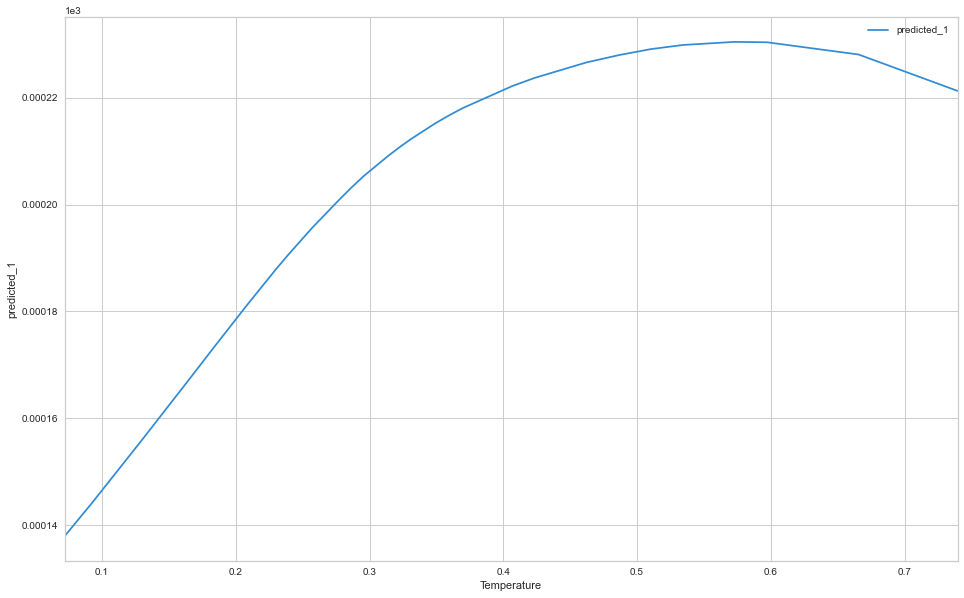

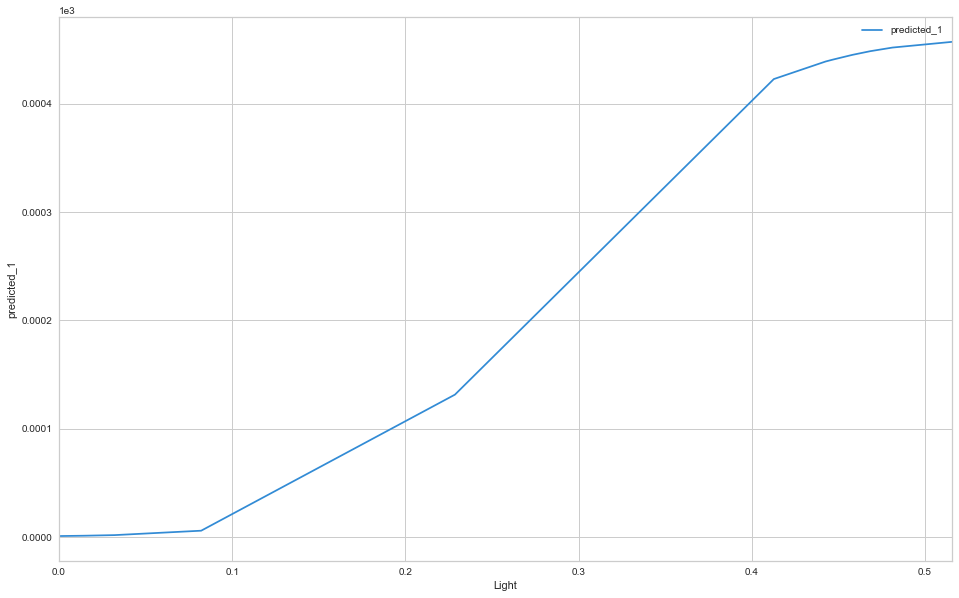

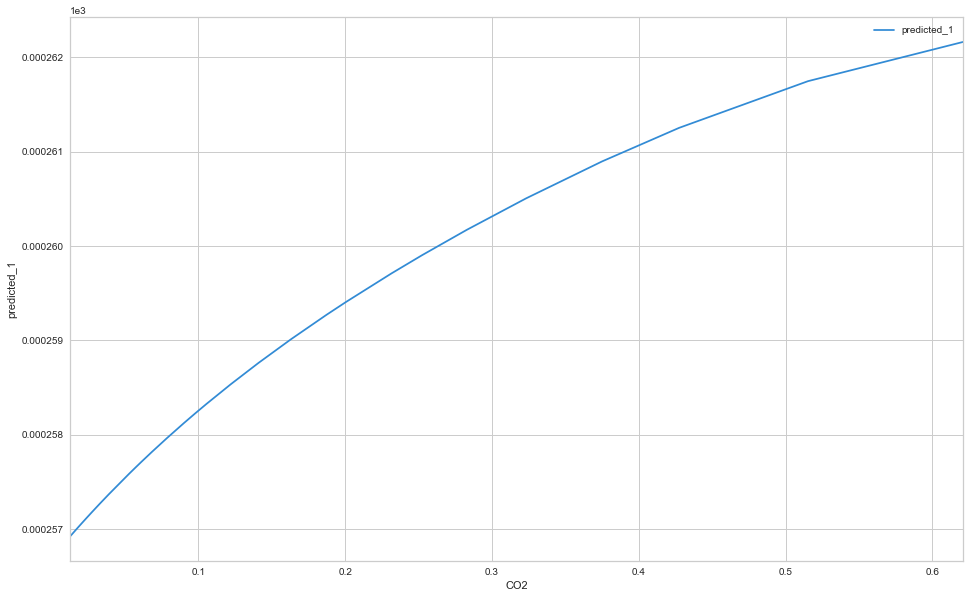

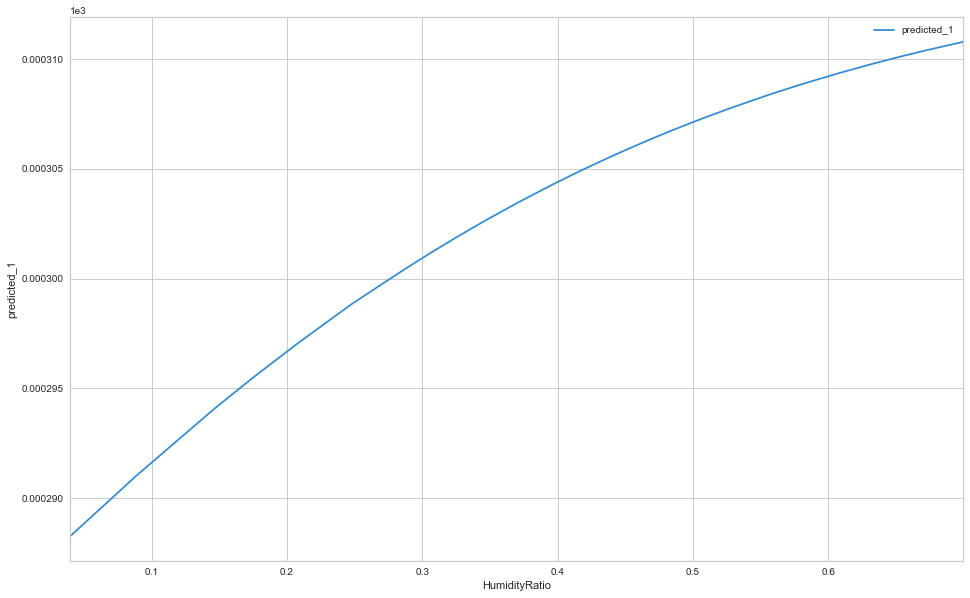

In [91]:
model = InMemoryModel(bb_predict_proba, examples=X_test)
#Facciamo il partial dependence plot rispetto a quelle due features e vediamo come varia la probabilità della classe 1
interpreter.partial_dependence.plot_partial_dependence([feature_names[0], feature_names[1],feature_names[2],feature_names[3]], 
                                                       model, n_samples=100, n_jobs=1)
plt.show()

### Explanation - Local Explanation
### LORE

In [209]:
from lorem import LOREM #Lorem perchè è una collezione di metodi

In [210]:
#Record da testare
i_list=[i for i in range(0, 1000, 10)]
#Insieme di valori associati ai record
x_list =[]### Explanation - Local Explanation
### LORE

from lorem import LOREM #Lorem perchè è una collezione di metodi

#Record da testare
i_list=[i for i in range(0, 1000, 10)]
#Insieme di valori associati ai record
x_list =[]
for i in i_list:
    x_list.append((X_test[i], i))

lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                   neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                   size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                   verbose=True)

exp_list = []
for x, i in x_list:
    exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)
    exp_list.append((exp, i))


for exp, i in exp_list:
    print("Explanation per il record: " + str(i))
    print(exp) #Qua abbiamo l'explanation, la regola e in basse il counter factor 
for i in i_list:
    x_list.append((X_test[i], i))

In [211]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                   neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                   size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                   verbose=True)

calculating feature values


In [212]:
exp_list = []
for x, i in x_list:
    exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)
    exp_list.append((exp, i))


generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	133   	0.694927	0.462615	0.993306
2  	129   	0.845961	0.41574 	0.993306
3  	128   	0.908706	0.315503	0.993306
4  	132   	0.940896	0.467644	0.993306
5  	126   	0.941103	0.467191	0.993306
6  	134   	0.946398	0.438693	0.993306
7  	125   	0.900883	0.479948	0.993306
8  	130   	0.952541	0.469815	0.993306
9  	127   	0.935667	0.432635	0.993305
10 	126   	0.938344	0.470905	0.993305
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.558053	0.408039	0.986674
2  	119   	0.632724	0.410422	0.990542
3  	128   	0.768803	0.34174 	0.990542
4  	131   	0.819646	0.260805	0.990542
5  	130   	0.844384	0.391907	0.990542
6  	134   	0.868728	0.378203	0.990766
7  	128   	0.859667	0.431455	0.990766
8  	133   	0.893069	0.443405	0.990766
9  	129   	0.866224	0.407512	0.990568
10 	135   	0.865118	0.41424 	0.990333
synthetic neighborhood class counts {0: 169, 1: 191}
learning local decision tree
r

gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	131   	0.70914 	0.488445	0.993305
2  	129   	0.907203	0.417293	0.993306
3  	128   	0.958457	0.462069	0.993306
4  	126   	0.94928 	0.482212	0.993306
5  	119   	0.969571	0.463304	0.993306
6  	135   	0.944443	0.455434	0.993306
7  	128   	0.969665	0.482744	0.993306
8  	128   	0.962613	0.449427	0.993307
9  	135   	0.963204	0.45922 	0.993307
10 	125   	0.960249	0.474574	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	139   	0.523472	0.469362	0.98526
2  	132   	0.610144	0.441353	0.991255
3  	127   	0.694962	0.343437	0.991329
4  	127   	0.821844	0.445135	0.991364
5  	124   	0.861111	0.422396	0.991342
6  	135   	0.855862	0.463865	0.991329
7  	133   	0.876901	0.445145	0.991681
8  	129   	0.850629	0.420971	0.991719
9  	122   	0.880092	0.42378 	0.991719
10 	122   	0.908261	0.471598	0.991719
synthetic neighborhood class counts {0: 176, 1: 184}
learning local decision tree
retrieving explanation
generating nei

2  	125   	0.920151	0.484143	0.993307
3  	129   	0.959247	0.485439	0.993206
4  	125   	0.970684	0.479007	0.993305
5  	134   	0.96724 	0.481631	0.993307
6  	126   	0.962384	0.483209	0.993307
7  	122   	0.955401	0.450205	0.993307
8  	133   	0.956786	0.481439	0.993307
9  	122   	0.956361	0.461855	0.993307
10 	131   	0.952554	0.45743 	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.54324	0.467366	0.9881
2  	131   	0.623377	0.468599	0.98916
3  	130   	0.773471	0.436564	0.989316
4  	129   	0.856144	0.433095	0.989324
5  	129   	0.871601	0.467133	0.989642
6  	123   	0.890356	0.468401	0.989642
7  	129   	0.896998	0.466496	0.98943 
8  	130   	0.885094	0.464527	0.989494
9  	134   	0.907833	0.468396	0.989664
10 	121   	0.874085	0.462994	0.989664
synthetic neighborhood class counts {0: 178, 1: 182}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	130   	0.705205	

4  	127   	0.972759	0.435576	0.993307
5  	121   	0.987664	0.9426  	0.993307
6  	134   	0.987159	0.952783	0.993307
7  	131   	0.980433	0.475233	0.993307
8  	123   	0.985434	0.512672	0.993307
9  	123   	0.98855 	0.934828	0.993307
10 	118   	0.985842	0.613988	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	133   	0.498451	0.44755	0.940008
2  	133   	0.503969	0.448711	0.955352
3  	116   	0.504364	0.456123	0.955352
4  	131   	0.518181	0.464683	0.955352
5  	133   	0.564915	0.380091	0.959391
6  	131   	0.6303  	0.438568	0.963815
7  	124   	0.686604	0.382662	0.963815
8  	122   	0.746871	0.363392	0.963929
9  	131   	0.795827	0.369324	0.963929
10 	128   	0.811166	0.42275 	0.966698
synthetic neighborhood class counts {0: 199, 1: 161}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.703919	0.480598	0.993287
2  	130   	0.91017 	0.364943	0.993291
3  	133   	0.9671

7  	126   	0.977407	0.485557	0.993307
8  	123   	0.973408	0.495024	0.993307
9  	130   	0.970087	0.487421	0.993307
10 	136   	0.980215	0.484796	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	131   	0.506558	0.475338	0.966747
2  	140   	0.527293	0.479816	0.980973
3  	120   	0.577614	0.469525	0.981685
4  	125   	0.655438	0.441559	0.981685
5  	132   	0.745165	0.447627	0.981685
6  	123   	0.802718	0.454674	0.981685
7  	136   	0.810801	0.451471	0.981956
8  	124   	0.860325	0.445439	0.981956
9  	132   	0.865727	0.467667	0.981956
10 	131   	0.855688	0.445074	0.981956
synthetic neighborhood class counts {0: 194, 1: 166}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	129   	0.733291	0.432007	0.993307
2  	135   	0.90226 	0.442716	0.993307
3  	126   	0.945169	0.43104 	0.993307
4  	118   	0.976166	0.422481	0.993307
5  	126   	0.94051 	0.445448	0.993307
6  	117   	0.943

8  	133   	0.962753	0.480952	0.993307
9  	128   	0.953732	0.486   	0.993307
10 	130   	0.959774	0.467837	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	129   	0.519871	0.472979	0.987853
2  	136   	0.561238	0.468314	0.991082
3  	124   	0.658768	0.472519	0.991082
4  	130   	0.790672	0.466999	0.991086
5  	131   	0.865275	0.407458	0.991173
6  	128   	0.866813	0.446648	0.991268
7  	131   	0.89297 	0.450492	0.991127
8  	125   	0.887436	0.441355	0.991191
9  	136   	0.86676 	0.453009	0.991357
10 	124   	0.874273	0.468767	0.991357
synthetic neighborhood class counts {0: 181, 1: 179}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	125   	0.719733	0.466086	0.993306
2  	133   	0.924767	0.460903	0.993306
3  	123   	0.953913	0.440719	0.993307
4  	123   	0.974571	0.466482	0.993307
5  	132   	0.971947	0.440909	0.993307
6  	123   	0.963001	0.451274	0.993307
7  	138   	0.966

9  	134   	0.961804	0.456676	0.993307
10 	122   	0.969045	0.483575	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	124   	0.50952	0.459991	0.97923
2  	125   	0.533869	0.468368	0.97923
3  	124   	0.554101	0.463806	0.97923
4  	133   	0.609323	0.459373	0.97923
5  	124   	0.679915	0.415391	0.97923
6  	136   	0.784878	0.367402	0.978571
7  	132   	0.811553	0.364902	0.979484
8  	131   	0.812635	0.411227	0.979638
9  	121   	0.859274	0.363211	0.979638
10 	127   	0.848302	0.454996	0.979638
synthetic neighborhood class counts {0: 188, 1: 172}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.754434	0.46206 	0.993306
2  	119   	0.965942	0.488754	0.993306
3  	129   	0.979447	0.495402	0.993306
4  	132   	0.965555	0.484785	0.993306
5  	130   	0.970586	0.489731	0.993307
6  	131   	0.957774	0.463008	0.993307
7  	128   	0.965619	0.478171	0.993307
8  	127   	0.968313	0.

1  	127   	0.568899	0.466021	0.987301
2  	121   	0.704151	0.465694	0.987301
3  	127   	0.880852	0.468153	0.987306
4  	130   	0.920096	0.464086	0.987301
5  	125   	0.944433	0.468655	0.987317
6  	127   	0.962302	0.486041	0.987317
7  	124   	0.96005 	0.461689	0.987331
8  	131   	0.940821	0.484893	0.987331
9  	132   	0.953232	0.488525	0.987331
10 	131   	0.956009	0.486399	0.987333
synthetic neighborhood class counts {0: 210, 1: 150}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.721429	0.496654	0.993297
2  	127   	0.936121	0.496654	0.993307
3  	125   	0.973102	0.472975	0.993307
4  	133   	0.984231	0.496654	0.993307
5  	133   	0.984824	0.461439	0.993307
6  	134   	0.981451	0.47981 	0.993307
7  	125   	0.982649	0.458065	0.993307
8  	128   	0.982631	0.496654	0.993307
9  	137   	0.988595	0.961964	0.993307
10 	135   	0.986348	0.795754	0.993307
gen	nevals	avg	min	max
0

2  	123   	0.511514	0.46514 	0.976931
3  	130   	0.527222	0.466911	0.978641
4  	117   	0.573927	0.466565	0.979429
5  	113   	0.672747	0.461885	0.980496
6  	134   	0.749814	0.426127	0.980073
7  	121   	0.820357	0.425148	0.980073
8  	126   	0.843527	0.423465	0.98093 
9  	124   	0.842545	0.416748	0.98093 
10 	123   	0.85976 	0.459768	0.980683
synthetic neighborhood class counts {0: 184, 1: 176}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	121   	0.691057	0.453332	0.993306
2  	131   	0.928158	0.420672	0.993306
3  	115   	0.960188	0.464342	0.993307
4  	121   	0.965737	0.435517	0.993307
5  	129   	0.983812	0.451997	0.993307
6  	131   	0.97547 	0.466005	0.993307
7  	133   	0.974035	0.467071	0.993306
8  	129   	0.980673	0.465991	0.993306
9  	132   	0.979831	0.44838 	0.993306
10 	134   	0.974135	0.461542	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	125   	0.502

3  	115   	0.569255	0.424799	0.977122
4  	126   	0.617846	0.434217	0.977126
5  	115   	0.734978	0.421841	0.977122
6  	123   	0.834266	0.394739	0.977122
7  	129   	0.851311	0.40846 	0.977122
8  	137   	0.841735	0.298074	0.977122
9  	127   	0.90275 	0.4401  	0.977715
10 	127   	0.842247	0.446362	0.977742
synthetic neighborhood class counts {0: 196, 1: 164}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	128   	0.619737	0.471115	0.993304
2  	135   	0.762288	0.272579	0.993304
3  	117   	0.866734	0.296282	0.993304
4  	121   	0.912628	0.29042 	0.993304
5  	121   	0.89959 	0.396968	0.993304
6  	122   	0.858132	0.410192	0.993305
7  	129   	0.885888	0.413206	0.993306
8  	128   	0.881987	0.41036 	0.993306
9  	139   	0.860883	0.403189	0.993306
10 	120   	0.86344 	0.467364	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	128   	0.632119	0.427538	0.990978
2  	128   	0.762

4  	133   	0.759307	0.425372	0.990052
5  	134   	0.813353	0.438674	0.991793
6  	129   	0.847966	0.462395	0.991659
7  	132   	0.878163	0.445445	0.991758
8  	125   	0.886728	0.452688	0.991778
9  	124   	0.860835	0.451209	0.992071
10 	122   	0.860917	0.472624	0.991778
synthetic neighborhood class counts {0: 189, 1: 171}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	121   	0.705055	0.445662	0.993305
2  	115   	0.906247	0.433906	0.993305
3  	122   	0.959853	0.454607	0.993306
4  	122   	0.960456	0.484958	0.993306
5  	126   	0.965868	0.483401	0.993306
6  	122   	0.950221	0.484629	0.993306
7  	133   	0.958708	0.480968	0.993306
8  	124   	0.965477	0.484077	0.993306
9  	123   	0.958518	0.485046	0.993306
10 	133   	0.969346	0.492854	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	129   	0.513027	0.466149	0.990566
2  	124   	0.554292	0.45613 	0.9914  
3  	135   	0.610

6  	126   	0.88609 	0.465639	0.991004
7  	124   	0.86629 	0.430481	0.991603
8  	123   	0.863171	0.466736	0.991611
9  	122   	0.89125 	0.483544	0.991611
10 	119   	0.851983	0.452525	0.991611
synthetic neighborhood class counts {0: 186, 1: 174}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.703913	0.440552	0.993303
2  	124   	0.918489	0.373113	0.993296
3  	130   	0.963506	0.381182	0.993296
4  	130   	0.977815	0.462181	0.993304
5  	132   	0.97442 	0.459122	0.993304
6  	129   	0.967582	0.456122	0.993304
7  	132   	0.957973	0.451661	0.993304
8  	121   	0.955942	0.430519	0.993304
9  	131   	0.968134	0.431175	0.993304
10 	130   	0.965167	0.44717 	0.993304
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.511321	0.449151	0.926997
2  	133   	0.53107 	0.450614	0.942885
3  	130   	0.567057	0.295878	0.971728
4  	134   	0.648148	0.345501	0.958475
5  	129   	0.740

7  	137   	0.793864	0.435356	0.981698
8  	137   	0.808886	0.431669	0.981856
9  	123   	0.836886	0.374377	0.981704
10 	128   	0.863053	0.43736 	0.981704
synthetic neighborhood class counts {0: 192, 1: 168}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	122   	0.667559	0.448153	0.993307
2  	125   	0.804902	0.425535	0.993307
3  	129   	0.881548	0.427976	0.993298
4  	122   	0.903793	0.434511	0.993298
5  	133   	0.877368	0.430609	0.993298
6  	138   	0.890527	0.424532	0.993298
7  	133   	0.904785	0.441555	0.993298
8  	127   	0.893339	0.411612	0.993298
9  	140   	0.882875	0.432842	0.993298
10 	125   	0.902445	0.479726	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	126   	0.578768	0.454607	0.99061
2  	132   	0.700351	0.448696	0.990482
3  	121   	0.882936	0.455245	0.990564
4  	128   	0.93541 	0.482723	0.990567
5  	126   	0.927288	0.448125	0.990701
6  	128   	0.9646

In [213]:
for exp, i in exp_list:
    print("Explanation per il record: " + str(i))
    print(exp) #Qua abbiamo l'explanation, la regola e in basse il counter factor 

Explanation per il record: 0
r = { Light <= 0.28, Temperature > 0.62, TimeSpan != EV } --> { Occupancy: 0 }
c = { { Light > 0.36 },
      { Temperature <= 0.62 },
      { TimeSpan = EV } }
Explanation per il record: 10
r = { Light <= 0.14 } --> { Occupancy: 0 }
c = { { Light > 0.14 },
      { Light > 0.24 } }
Explanation per il record: 20
r = { Light <= 0.26, TimeSpan = NI } --> { Occupancy: 0 }
c = { { Light > 0.26, TimeSpan = AF },
      { Light > 0.26, TimeSpan = EV },
      { Light > 0.26, TimeSpan = DA } }
Explanation per il record: 30
r = { Light <= 0.13 } --> { Occupancy: 0 }
c = { { Light > 0.13, WeekSpan = WD, TimeSpan != NI } }
Explanation per il record: 40
r = { Light <= 0.14 } --> { Occupancy: 0 }
c = { { Light > 0.47, TimeSpan = DA },
      { Light > 0.20, TimeSpan = AF },
      { Light > 0.47, TimeSpan = EV } }
Explanation per il record: 50
r = { Light > 0.16, CO2 > -0.04, TimeSpan = AF, HumidityRatio <= 0.72 } --> { Occupancy: 1 }
c = { { Light <= 0.16 } }
Explanation pe

### LIME

In [214]:
from lime.lime_tabular import LimeTabularExplainer

In [215]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [216]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [217]:
exp.local_exp #ottenniamo la lista delle feature e la loro importanza

{1: [(1, 0.10351016108700938),
  (8, 0.09943279016133956),
  (5, 0.03456348349368202),
  (6, 0.031528903278168464),
  (4, 0.023266783740557035),
  (2, 0.00810369968578802),
  (0, 0.005523101781204705),
  (7, -0.005165227670876821),
  (3, 0.004648045032772736),
  (9, -0.004368588286624003)]}

In [218]:
exp.show_in_notebook() #Qua abbiamo una visualizzazione (a destra abbiamo le feature che danno churn, a sinistra quelle
# che danno "not churn")

# Classification - Mutilayer Perceptron

In [219]:
from sklearn.neural_network import MLPClassifier

In [220]:
bb = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(12, 23, 11))
bb.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(12, 23, 11), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [221]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [222]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred))


Accuracy 0.990
F1-measure 0.979


**** Matrice di Confusione *****
 True negative: 4683 False negative: 2
 True positive: 1423 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9899
Numero di campioni correttamente correlati:  6106
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9595
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9986
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9787
____________________________________________
              precision    recall  f1-score   

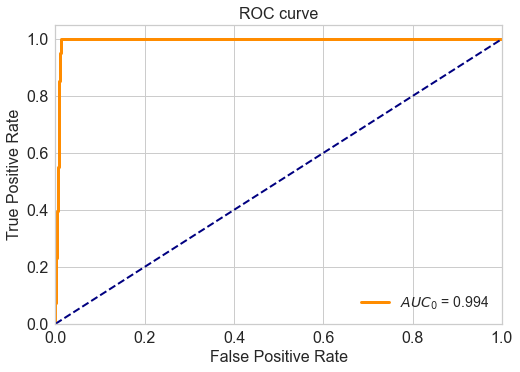

____________________________________
****** VALORE DI AUC *******
0.9944890901087846
____________________________________
****** ROC CURVE: con metodo diretto *******


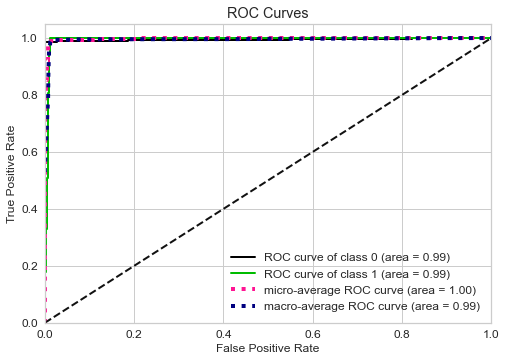

____________________________________
****** Precision recall: con metodo diretto *******


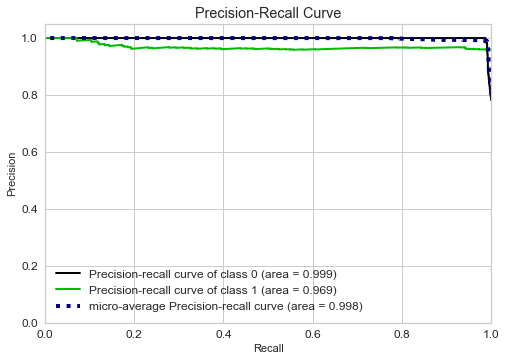

____________________________________
****** Cumulative gain: con metodo diretto *******


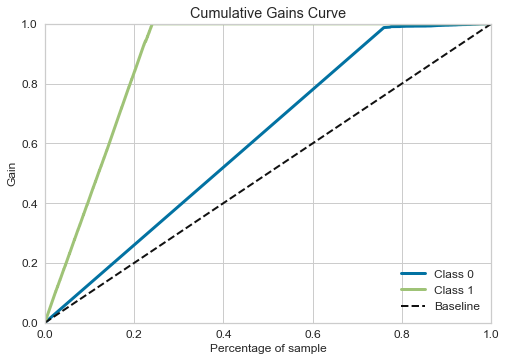

____________________________________
****** Lift curve: con metodo diretto *******


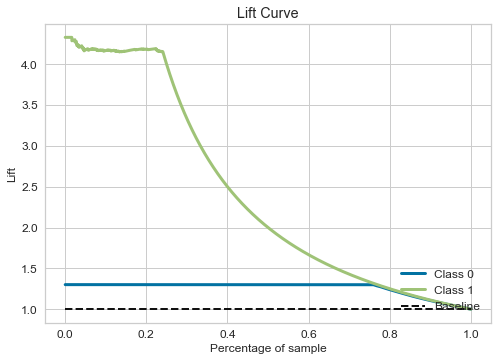

In [223]:
result_pred(y_test, y_pred)
y_score = bb.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

### Explanation - Global Explanation
### Partial Explanation Plot

In [124]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

from skater.core.global_interpretation.partial_dependence import PartialDependence

In [125]:
interpreter = Interpretation(X_train, feature_names=feature_names)

2020-06-10 22:43:52,534 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:43:57,310 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[28/28] grid cells ████████████████████ Time elapsed: 5 seconds

2020-06-10 22:43:58,607 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:44:00,242 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[12/12] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 22:44:01,079 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:44:02,866 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 22:44:04,194 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:44:05,786 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

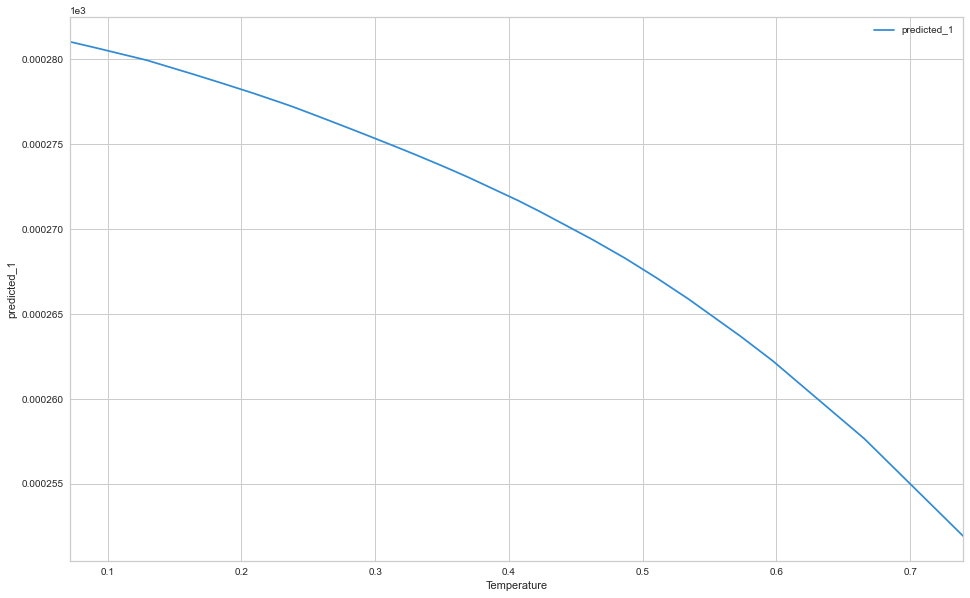

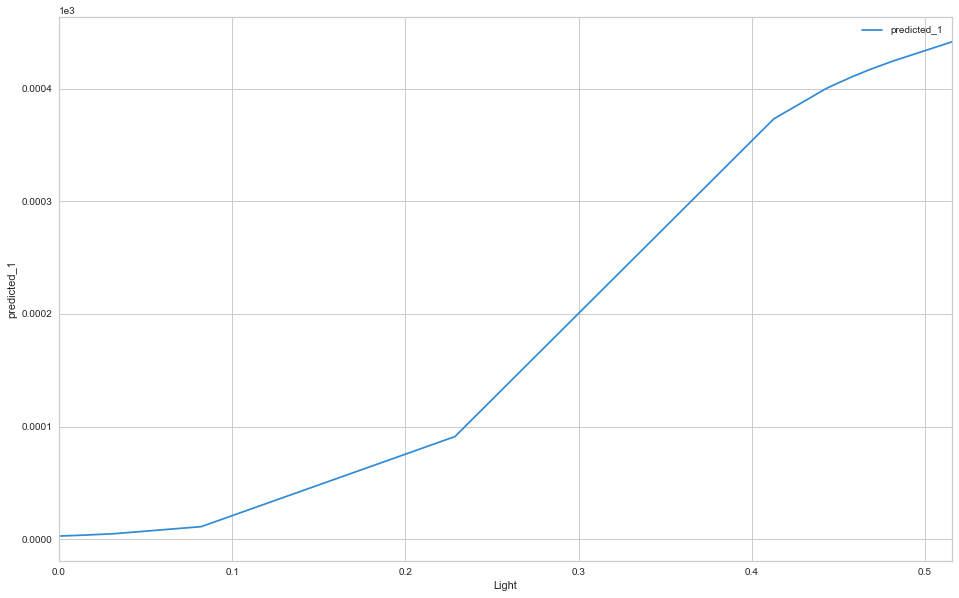

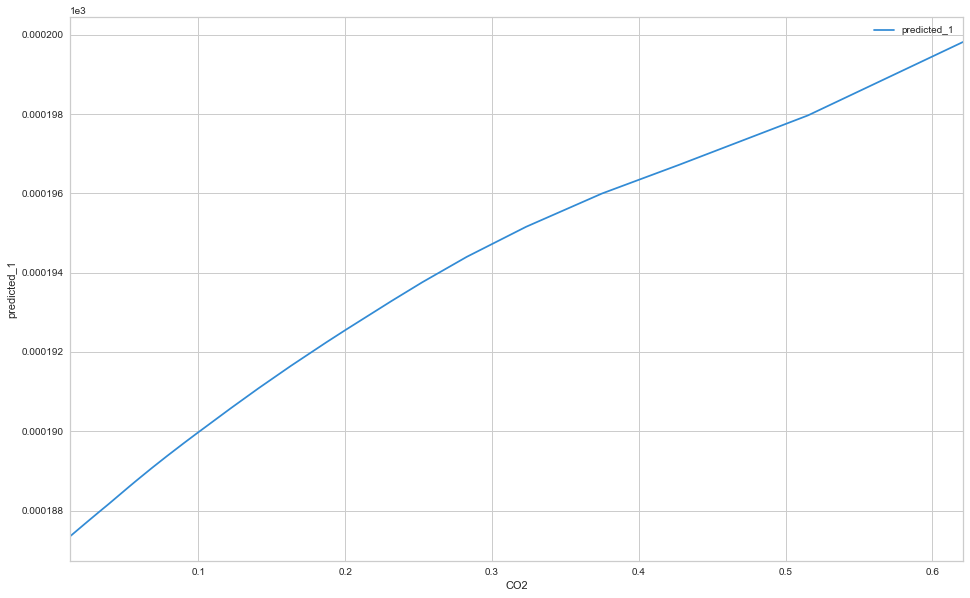

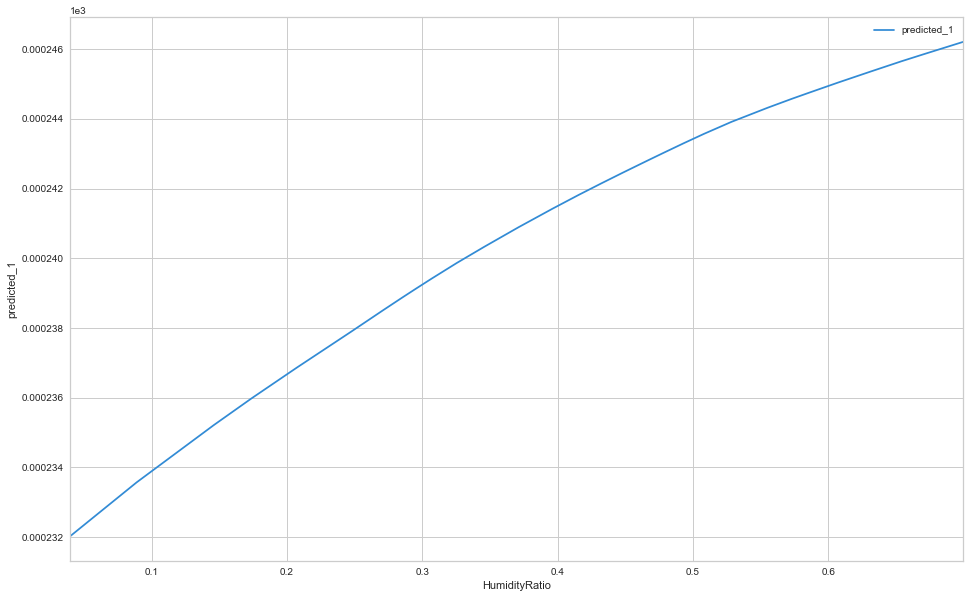

In [126]:
model = InMemoryModel(bb_predict_proba, examples=X_test)
#Facciamo il partial dependence plot rispetto a quelle due features e vediamo come varia la probabilità della classe 1
interpreter.partial_dependence.plot_partial_dependence([feature_names[0], feature_names[1],feature_names[2],feature_names[3]], 
                                                       model, n_samples=100, n_jobs=1)
plt.show()

### Explanation - Local Explanation
### LORE

In [224]:
from lorem import LOREM #Lorem perchè è una collezione di metodi

In [225]:
#Record da testare
i_list=[i for i in range(0, 1000, 10)]
#Insieme di valori associati ai record
x_list =[]
for i in i_list:
    x_list.append((X_test[i], i))

In [226]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                   neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                   size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                   verbose=True)

calculating feature values


In [227]:
exp_list = []
for x, i in x_list:
    exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)
    exp_list.append((exp, i))


generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	133   	0.723435	0.468212	0.993306
2  	129   	0.879672	0.467169	0.993306
3  	128   	0.951603	0.487452	0.993306
4  	132   	0.952375	0.473617	0.993306
5  	126   	0.957711	0.459238	0.993306
6  	134   	0.963245	0.480125	0.993304
7  	125   	0.930885	0.48578 	0.993304
8  	130   	0.969574	0.482079	0.993304
9  	127   	0.948244	0.471668	0.993304
10 	126   	0.943016	0.476515	0.993304
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.538479	0.39929	0.979003
2  	119   	0.582153	0.400845	0.985317
3  	128   	0.673454	0.304021	0.985317
4  	131   	0.760231	0.133717	0.985317
5  	130   	0.809448	0.321105	0.985317
6  	134   	0.853753	0.334269	0.985483
7  	128   	0.847198	0.430372	0.98546 
8  	133   	0.845098	0.418546	0.985855
9  	129   	0.844641	0.40539 	0.985555
10 	135   	0.827447	0.413998	0.985614
synthetic neighborhood class counts {0: 191, 1: 169}
learning local decision tree
re

2  	129   	0.906473	0.488911	0.993306
3  	128   	0.95561 	0.487667	0.993306
4  	126   	0.965787	0.455088	0.993306
5  	119   	0.963657	0.49324 	0.993306
6  	135   	0.969954	0.481545	0.993306
7  	128   	0.971453	0.48274 	0.993306
8  	128   	0.967075	0.491087	0.993307
9  	135   	0.972828	0.475326	0.993306
10 	125   	0.962903	0.480668	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	139   	0.51334	0.463779	0.986973
2  	132   	0.573383	0.458137	0.987487
3  	127   	0.654127	0.44951 	0.988211
4  	127   	0.758595	0.43685 	0.988357
5  	124   	0.854026	0.46581 	0.988415
6  	135   	0.83651 	0.466837	0.988357
7  	133   	0.869403	0.445589	0.988514
8  	129   	0.84338 	0.450469	0.988667
9  	122   	0.874912	0.456161	0.988705
10 	122   	0.856854	0.453165	0.988705
synthetic neighborhood class counts {0: 194, 1: 166}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	133   	0.6464

4  	125   	0.956141	0.451957	0.993307
5  	134   	0.956405	0.483648	0.993307
6  	126   	0.955164	0.487044	0.993307
7  	122   	0.952382	0.487652	0.993307
8  	133   	0.950968	0.479197	0.993307
9  	122   	0.953696	0.485715	0.993307
10 	131   	0.958701	0.487791	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.524177	0.469032	0.989069
2  	131   	0.56072 	0.457468	0.989325
3  	130   	0.608293	0.461457	0.989106
4  	129   	0.730605	0.456962	0.989106
5  	129   	0.819308	0.425856	0.98931 
6  	123   	0.848981	0.408917	0.98931 
7  	129   	0.862332	0.452984	0.989434
8  	130   	0.836292	0.458558	0.989434
9  	134   	0.874908	0.438554	0.989585
10 	121   	0.852894	0.471834	0.989585
synthetic neighborhood class counts {0: 195, 1: 165}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	130   	0.680203	0.484363	0.993307
2  	129   	0.914602	0.45029 	0.993307
3  	132   	0.971

6  	134   	0.987252	0.925555	0.993304
7  	131   	0.986459	0.934903	0.993306
8  	123   	0.988524	0.931832	0.993304
9  	123   	0.987769	0.940836	0.993304
10 	118   	0.988597	0.941473	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	133   	0.495306	0.456123	0.5
2  	133   	0.494852	0.45736 	0.5
3  	116   	0.496169	0.468038	0.5
4  	131   	0.493906	0.451452	0.5
5  	133   	0.493903	0.447326	0.5
6  	131   	0.495718	0.460341	0.5
7  	124   	0.494045	0.437292	0.5
8  	122   	0.493643	0.446624	0.5
9  	131   	0.494883	0.44109 	0.5
10 	128   	0.495142	0.463224	0.5
synthetic neighborhood class counts {0: 330, 1: 30}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.691758	0.496654	0.993294
2  	130   	0.928617	0.496654	0.993294
3  	133   	0.9742  	0.451204	0.993294
4  	124   	0.977418	0.49594 	0.993293
5  	131   	0.98821 	0.935581	0.993293
6  	120   	0.969965	0.488036	

9  	130   	0.974973	0.476291	0.993307
10 	136   	0.988314	0.690168	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	131   	0.495682	0.45873	0.529742
2  	140   	0.497466	0.473791	0.558093
3  	120   	0.504098	0.475425	0.975379
4  	125   	0.512405	0.44675 	0.981123
5  	132   	0.524988	0.455224	0.981123
6  	123   	0.554885	0.457548	0.981123
7  	136   	0.611184	0.445867	0.981123
8  	124   	0.700635	0.441448	0.984175
9  	132   	0.786893	0.448304	0.984175
10 	131   	0.844189	0.446019	0.984175
synthetic neighborhood class counts {0: 199, 1: 161}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	129   	0.714001	0.464748	0.993307
2  	135   	0.924286	0.473026	0.993307
3  	126   	0.956685	0.475626	0.993303
4  	118   	0.948554	0.473377	0.993307
5  	126   	0.959331	0.485475	0.993307
6  	117   	0.959548	0.493113	0.993307
7  	129   	0.947844	0.483917	0.993307
8  	123   	0.9644

2  	136   	0.551293	0.472004	0.986948
3  	124   	0.621141	0.438124	0.986948
4  	130   	0.719263	0.455836	0.987334
5  	131   	0.786314	0.440086	0.987706
6  	128   	0.82293 	0.431778	0.987862
7  	131   	0.829324	0.459396	0.987862
8  	125   	0.847772	0.440088	0.987862
9  	136   	0.87841 	0.464262	0.98796 
10 	124   	0.86932 	0.445604	0.98796 
synthetic neighborhood class counts {0: 194, 1: 166}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	125   	0.746287	0.496654	0.993302
2  	133   	0.965336	0.496654	0.9933  
3  	123   	0.983768	0.934111	0.993298
4  	123   	0.984674	0.758775	0.993299
5  	132   	0.985847	0.916704	0.993299
6  	123   	0.988012	0.947608	0.993303
7  	138   	0.986999	0.889324	0.993305
8  	124   	0.986787	0.677977	0.993305
9  	124   	0.987239	0.935109	0.993305
10 	133   	0.983542	0.496654	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.496

5  	124   	0.608126	0.425478	0.984567
6  	136   	0.683022	0.396391	0.98445 
7  	132   	0.784514	0.3743  	0.984945
8  	131   	0.78007 	0.419373	0.985005
9  	121   	0.829067	0.45756 	0.985005
10 	127   	0.825713	0.406747	0.985348
synthetic neighborhood class counts {0: 208, 1: 152}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.756244	0.487813	0.993307
2  	119   	0.953467	0.471553	0.993307
3  	129   	0.984871	0.554085	0.993307
4  	132   	0.975741	0.496498	0.993307
5  	130   	0.977045	0.496654	0.993307
6  	131   	0.979494	0.486299	0.993307
7  	128   	0.980277	0.496654	0.993307
8  	127   	0.986192	0.496654	0.993307
9  	110   	0.990341	0.948611	0.993307
10 	116   	0.979125	0.496654	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	138   	0.496053	0.466988	0.5
2  	130   	0.496724	0.470773	0.500572
3  	121   	0.503676	0.454403	0.938643
4  	133   	0.517132	0

8  	131   	0.93334 	0.465416	0.984876
9  	132   	0.941483	0.479507	0.984876
10 	131   	0.950712	0.466749	0.984887
synthetic neighborhood class counts {0: 219, 1: 141}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.720532	0.496654	0.993307
2  	127   	0.956197	0.496654	0.993307
3  	125   	0.979601	0.496654	0.993307
4  	133   	0.984161	0.496654	0.993307
5  	133   	0.988246	0.943577	0.993307
6  	134   	0.987281	0.939802	0.993307
7  	125   	0.988814	0.955639	0.993307
8  	128   	0.988915	0.956645	0.993307
9  	137   	0.987516	0.952513	0.993307
10 	135   	0.985421	0.496654	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	118   	0.494842	0.465214	0.5
2  	132   	0.495409	0.459582	0.5
3  	123   	0.496371	0.472522	0.5
4  	121   	0.495255	0.469552	0.5
5  	135   	0.495726	0.444351	0.5
6  	129   	0.494511	0.467394	0.5
7  	127   	0.493086	0.457029	0.5
8  	134   	0.

generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	121   	0.697457	0.496654	0.993303
2  	131   	0.9411  	0.496654	0.993306
3  	115   	0.986147	0.92791 	0.993306
4  	121   	0.98784 	0.95678 	0.993306
5  	129   	0.987546	0.934513	0.993307
6  	131   	0.988358	0.948947	0.993307
7  	133   	0.985718	0.894609	0.993307
8  	129   	0.98093 	0.496654	0.993307
9  	132   	0.982648	0.496654	0.993307
10 	134   	0.981668	0.496654	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	125   	0.495366	0.458918	0.540056
2  	127   	0.495107	0.457191	0.5     
3  	134   	0.494675	0.458275	0.5     
4  	134   	0.49475 	0.449862	0.5     
5  	128   	0.49307 	0.45275 	0.5     
6  	132   	0.494758	0.451789	0.5     
7  	119   	0.496528	0.458705	0.5     
8  	126   	0.49531 	0.459049	0.5     
9  	134   	0.494677	0.454179	0.5     
10 	127   	0.493716	0.459662	0.5     
synthetic neighborhood class counts {0: 329, 1: 31}
learning local decision tree
re

3  	117   	0.85873 	0.408624	0.993306
4  	121   	0.845211	0.393355	0.993307
5  	121   	0.872832	0.424298	0.993307
6  	122   	0.866476	0.403926	0.993306
7  	129   	0.87029 	0.396212	0.993306
8  	128   	0.886508	0.39602 	0.993306
9  	139   	0.842678	0.413782	0.993307
10 	120   	0.856601	0.420402	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	128   	0.647899	0.432395	0.989601
2  	128   	0.831882	0.425298	0.989776
3  	113   	0.948722	0.420853	0.989776
4  	132   	0.947525	0.471989	0.989776
5  	131   	0.947665	0.478094	0.989776
6  	125   	0.956253	0.468769	0.989776
7  	133   	0.959278	0.480841	0.989776
8  	121   	0.934656	0.477185	0.989776
9  	127   	0.960374	0.482251	0.989776
10 	131   	0.946171	0.482729	0.989796
synthetic neighborhood class counts {0: 224, 1: 136}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.748827	0.496654	0.993279
2  	123   	0.959

5  	126   	0.965703	0.48653 	0.993307
6  	122   	0.950216	0.485381	0.993307
7  	133   	0.974944	0.491965	0.993307
8  	124   	0.965775	0.45092 	0.993307
9  	123   	0.979784	0.486246	0.993307
10 	133   	0.951708	0.49056 	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	129   	0.522765	0.457181	0.987603
2  	124   	0.546632	0.450732	0.986653
3  	135   	0.600554	0.452392	0.987439
4  	125   	0.73484 	0.415545	0.987439
5  	133   	0.756331	0.365984	0.988438
6  	120   	0.828013	0.435972	0.988438
7  	130   	0.83824 	0.462528	0.988505
8  	131   	0.831621	0.454063	0.988468
9  	126   	0.810669	0.450783	0.988854
10 	120   	0.81532 	0.444856	0.988856
synthetic neighborhood class counts {0: 202, 1: 158}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.705052	0.487901	0.993305
2  	137   	0.899631	0.470903	0.993305
3  	127   	0.961025	0.479268	0.993307
4  	123   	0.968

7  	132   	0.986275	0.931633	0.993306
8  	121   	0.987143	0.922985	0.993306
9  	131   	0.987197	0.932948	0.993306
10 	130   	0.985638	0.861239	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.493936	0.443933	0.5
2  	133   	0.492045	0.424239	0.5
3  	130   	0.492138	0.405044	0.5
4  	134   	0.494147	0.44664 	0.5
5  	129   	0.490771	0.41494 	0.5
6  	125   	0.49181 	0.422174	0.5
7  	139   	0.491148	0.416034	0.5
8  	124   	0.495907	0.439957	0.878209
9  	129   	0.506095	0.36769 	0.878209
10 	111   	0.505748	0.363712	0.878209
synthetic neighborhood class counts {0: 309, 1: 39}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	125   	0.585196	0.42637 	0.993275
2  	131   	0.687162	0.303835	0.993261
3  	124   	0.826988	0.382873	0.993307
4  	133   	0.865468	0.417976	0.993307
5  	127   	0.894717	0.420756	0.993307
6  	126   	0.85466 	0.383716	0.993307
7  	137   	0.8

10 	125   	0.894076	0.443548	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	126   	0.611837	0.47937	0.990879
2  	132   	0.800988	0.451681	0.990989
3  	121   	0.920003	0.47357 	0.991087
4  	128   	0.929401	0.475548	0.991087
5  	126   	0.949774	0.485211	0.991037
6  	128   	0.958845	0.481472	0.991037
7  	132   	0.942281	0.48206 	0.991037
8  	120   	0.944291	0.482024	0.991037
9  	124   	0.96333 	0.486619	0.991044
10 	124   	0.940982	0.485473	0.991073
synthetic neighborhood class counts {0: 213, 1: 147}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	131   	0.624289	0.444143	0.993305
2  	115   	0.749851	0.428016	0.993305
3  	127   	0.824981	0.410813	0.993269
4  	129   	0.864   	0.422679	0.993287
5  	129   	0.87354 	0.425405	0.993269
6  	129   	0.853662	0.32146 	0.993276
7  	138   	0.847771	0.374176	0.993307
8  	139   	0.833464	0.431843	0.993307
9  	125   	0.8440

In [228]:
for exp, i in exp_list:
    print("Explanation per il record: " + str(i))
    print(exp) #Qua abbiamo l'explanation, la regola e in basse il counter factor 

Explanation per il record: 0
r = { Light <= 0.28, TimeSpan != AF, Temperature > 0.03, CO2 <= 0.47, TimeSpan != EV } --> { Occupancy: 0 }
c = { { Light > 0.33 },
      { Temperature <= 0.03 } }
Explanation per il record: 10
r = { Light <= 0.17 } --> { Occupancy: 0 }
c = { { Light > 0.26 },
      { Light > 0.17 } }
Explanation per il record: 20
r = { Light <= 0.51, TimeSpan = NI } --> { Occupancy: 0 }
c = { { Light > 0.55 },
      { Light > 0.51 } }
Explanation per il record: 30
r = { WeekSpan = WE } --> { Occupancy: 0 }
c =  }
Explanation per il record: 40
r = { Light <= 0.43 } --> { Occupancy: 0 }
c = { { Light > 0.56 } }
Explanation per il record: 50
r = { Light > 0.26, WeekSpan != WE, Temperature <= 0.80 } --> { Occupancy: 1 }
c = { { WeekSpan = WE },
      { Light <= 0.18 } }
Explanation per il record: 60
r = { Light > 0.33, WeekSpan != WE, TimeSpan != NI } --> { Occupancy: 1 }
c = { { Light <= 0.24 },
      { WeekSpan = WE } }
Explanation per il record: 70
r = { Light <= 0.34, Time

### LIME

In [164]:
from lime.lime_tabular import LimeTabularExplainer

In [165]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [166]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [167]:
exp.local_exp #ottenniamo la lista delle feature e la loro importanza

{1: [(1, 0.07932270327249419),
  (9, -0.07012874204050044),
  (7, -0.060735289484764546),
  (8, 0.03428817350298057),
  (5, 0.017901156565784913),
  (4, 0.01569182020355519),
  (0, -0.01438140100589488),
  (6, 0.011479572368137958),
  (3, 0.009854123617668235),
  (2, 0.008833206049101571)]}

In [168]:
exp.show_in_notebook() #Qua abbiamo una visualizzazione (a destra abbiamo le feature che danno churn, a sinistra quelle
# che danno "not churn")

# Classification - AdaBoost

In [229]:
from sklearn.ensemble import AdaBoostClassifier

In [230]:
bb = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 5)
bb.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=5, random_state=None)

In [231]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [232]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred))

Accuracy 0.988
F1-measure 0.975


**** Matrice di Confusione *****
 True negative: 4677 False negative: 7
 True positive: 1418 False positive: 66
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9882
Numero di campioni correttamente correlati:  6095
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9555
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9951
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9861
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9749
____________________________________________
              precision    recall  f1-score   

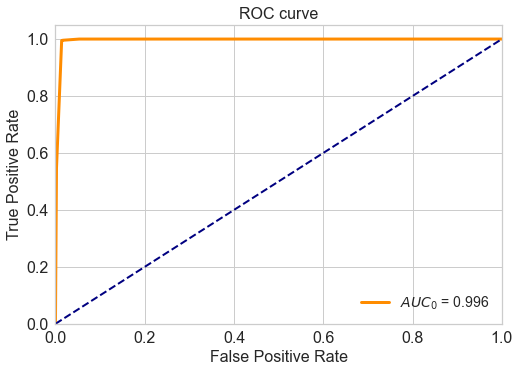

____________________________________
****** VALORE DI AUC *******
0.9955684277106429
____________________________________
****** ROC CURVE: con metodo diretto *******


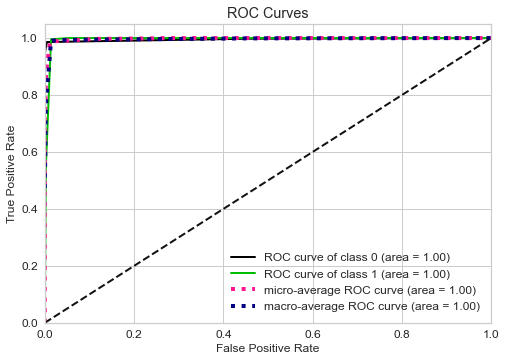

____________________________________
****** Precision recall: con metodo diretto *******


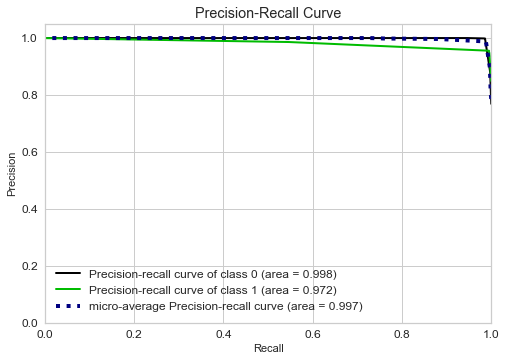

____________________________________
****** Cumulative gain: con metodo diretto *******


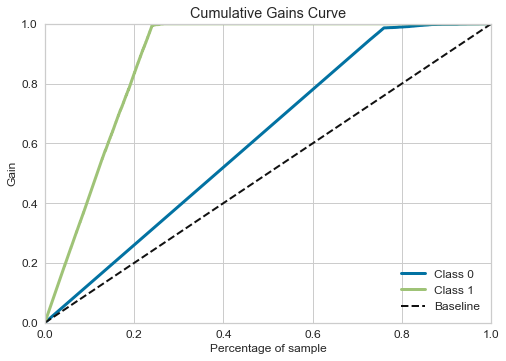

____________________________________
****** Lift curve: con metodo diretto *******


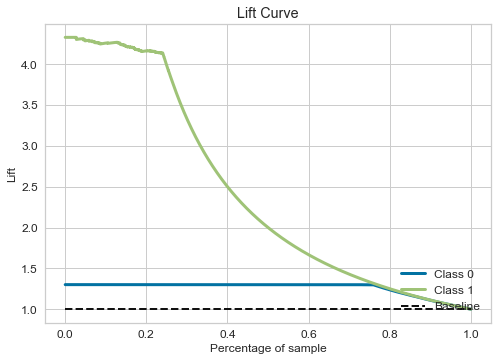

In [233]:
result_pred(y_test, y_pred)
y_score = bb.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

### Explanation - Global Explanation
### Partial Explanation Plot

In [136]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

from skater.core.global_interpretation.partial_dependence import PartialDependence

In [137]:
interpreter = Interpretation(X_train, feature_names=feature_names)

2020-06-10 22:48:48,701 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:48:50,389 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[28/28] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 22:48:51,569 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:48:53,154 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[12/12] grid cells ████████████████████ Time elapsed: 1 seconds

2020-06-10 22:48:53,936 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:48:55,530 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-10 22:48:56,911 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-10 22:48:58,575 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

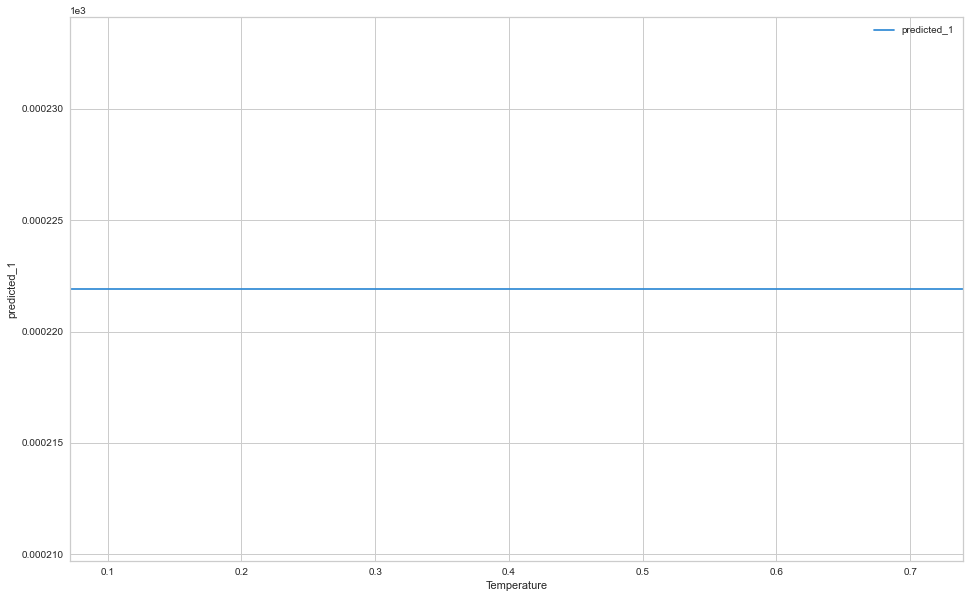

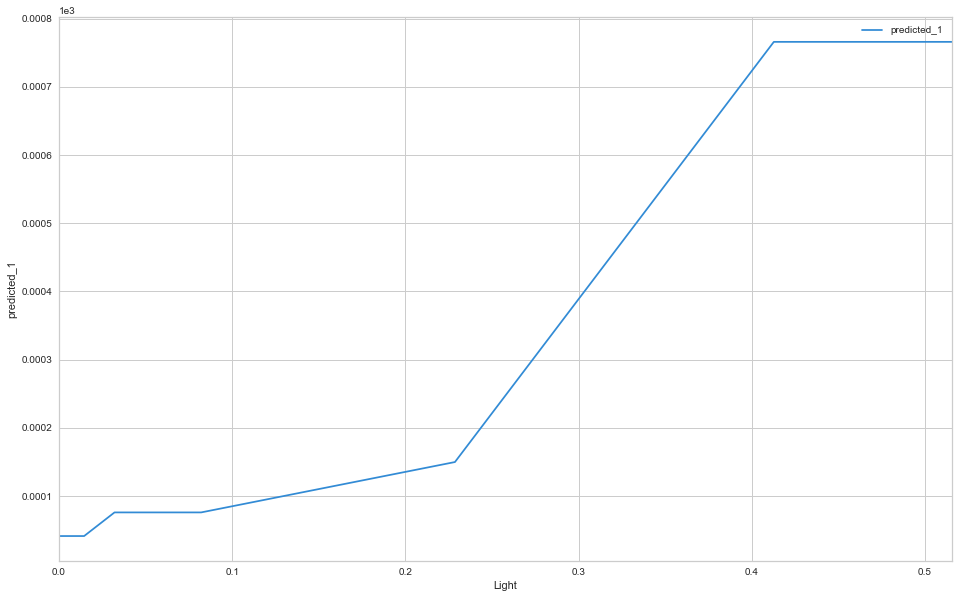

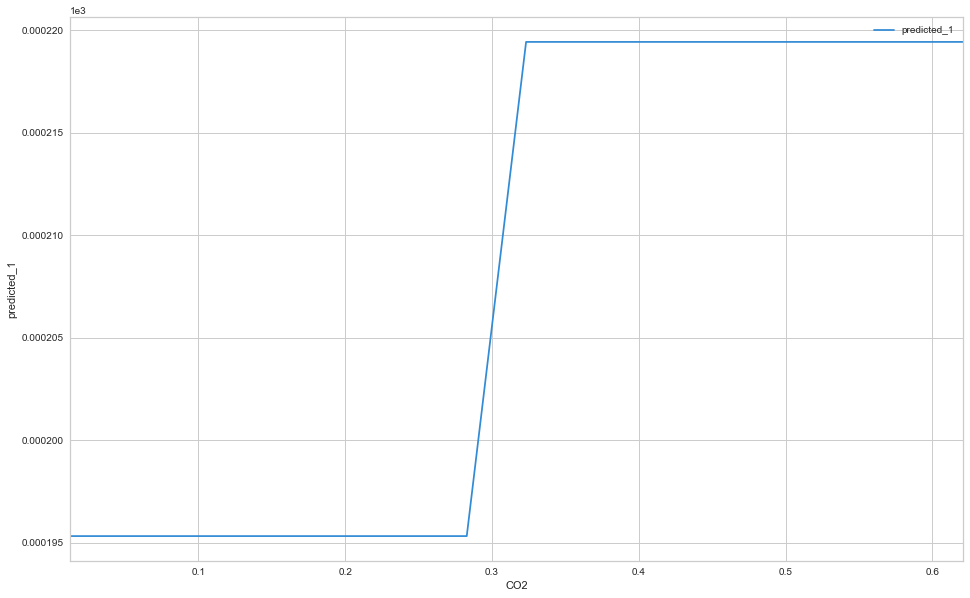

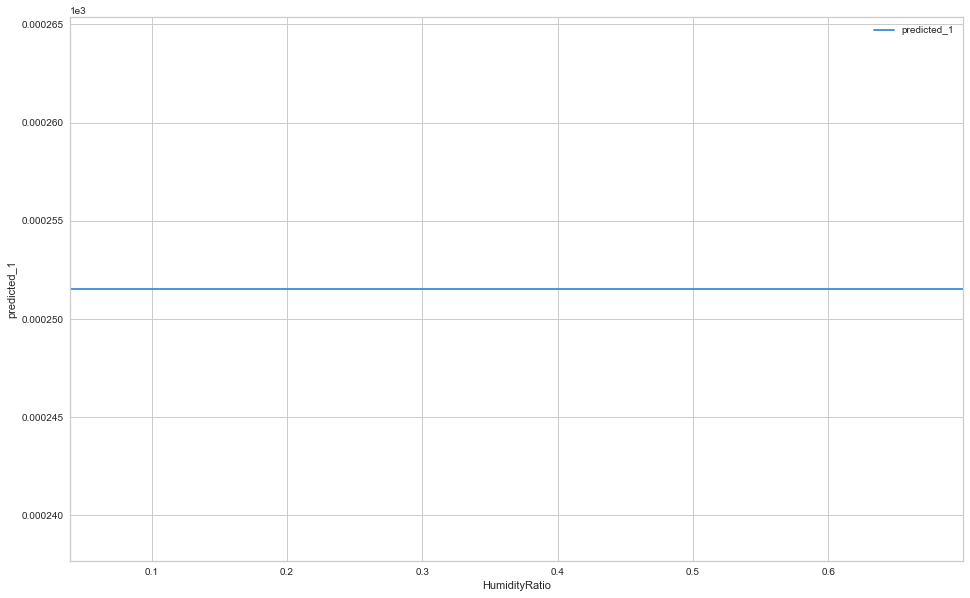

In [138]:
model = InMemoryModel(bb_predict_proba, examples=X_test)
#Facciamo il partial dependence plot rispetto a quelle due features e vediamo come varia la probabilità della classe 1
interpreter.partial_dependence.plot_partial_dependence([feature_names[0], feature_names[1],feature_names[2],feature_names[3]], 
                                                       model, n_samples=100, n_jobs=1)
plt.show()

### Explanation - Local Explanation
### LORE

In [234]:
from lorem import LOREM #Lorem perchè è una collezione di metodi

In [235]:
#Record da testare
i_list=[i for i in range(0, 1000, 10)]
#Insieme di valori associati ai record
x_list =[]
for i in i_list:
    x_list.append((X_test[i], i))

In [236]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                   neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                   size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                   verbose=True)

calculating feature values


In [237]:
exp_list = []
for x, i in x_list:
    exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)
    exp_list.append((exp, i))


generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	133   	0.745743	0.496654	0.993306
2  	129   	0.908212	0.496654	0.993306
3  	128   	0.95579 	0.431318	0.993306
4  	132   	0.97191 	0.607135	0.993306
5  	126   	0.96365 	0.591665	0.993306
6  	134   	0.972189	0.588245	0.993306
7  	125   	0.956076	0.50007 	0.993306
8  	130   	0.974514	0.496654	0.993306
9  	127   	0.963789	0.616015	0.993306
10 	126   	0.961159	0.612038	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.519514	0.399268	0.79744
2  	119   	0.544044	0.414667	0.831609
3  	128   	0.609878	0.342002	0.862212
4  	131   	0.680955	0.415633	0.859315
5  	130   	0.711937	0.33144 	0.86822 
6  	134   	0.744146	0.394269	0.873892
7  	128   	0.740117	0.304726	0.873892
8  	133   	0.767795	0.395466	0.876685
9  	129   	0.7583  	0.295196	0.876795
10 	135   	0.749062	0.335376	0.876795
synthetic neighborhood class counts {0: 187, 1: 173}
learning local decision tree
re

gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	131   	0.708248	0.496654	0.993303
2  	129   	0.91189 	0.496654	0.993307
3  	128   	0.963111	0.538854	0.993307
4  	126   	0.96559 	0.496654	0.993307
5  	119   	0.972785	0.528419	0.993303
6  	135   	0.968837	0.539715	0.993303
7  	128   	0.974526	0.571311	0.993303
8  	128   	0.967872	0.569675	0.993303
9  	135   	0.958793	0.540474	0.993306
10 	125   	0.975176	0.528039	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	139   	0.521916	0.467476	0.948927
2  	132   	0.554848	0.453903	0.950396
3  	127   	0.630793	0.460953	0.950396
4  	127   	0.738839	0.422645	0.950396
5  	124   	0.823536	0.46323 	0.950591
6  	135   	0.822517	0.428987	0.950591
7  	133   	0.841548	0.417365	0.950626
8  	129   	0.853992	0.463496	0.950492
9  	122   	0.843467	0.458673	0.950541
10 	122   	0.843659	0.423429	0.950541
synthetic neighborhood class counts {0: 191, 1: 169}
learning local decision tree
retrieving explanation
generating ne

1  	121   	0.712724	0.496654	0.993307
2  	125   	0.913139	0.496654	0.993307
3  	129   	0.948163	0.496654	0.993307
4  	125   	0.956572	0.496654	0.993307
5  	134   	0.955982	0.496654	0.993307
6  	126   	0.961554	0.496654	0.993307
7  	122   	0.961906	0.539017	0.993307
8  	133   	0.961903	0.496654	0.993307
9  	122   	0.96373 	0.496654	0.993307
10 	131   	0.954136	0.54935 	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.510502	0.466624	0.950511
2  	131   	0.532132	0.466748	0.950799
3  	130   	0.576217	0.466458	0.950799
4  	129   	0.648947	0.466493	0.950799
5  	129   	0.73839 	0.464549	0.950799
6  	123   	0.817179	0.431255	0.950845
7  	129   	0.859811	0.433099	0.95098 
8  	130   	0.859682	0.434598	0.95098 
9  	134   	0.835718	0.467129	0.950987
10 	121   	0.843138	0.467366	0.950987
synthetic neighborhood class counts {0: 184, 1: 176}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496

2  	128   	0.911053	0.496654	0.993307
3  	136   	0.952313	0.510215	0.993307
4  	127   	0.97599 	0.554701	0.993307
5  	121   	0.955876	0.496654	0.993307
6  	134   	0.960375	0.496654	0.993307
7  	131   	0.957214	0.496654	0.993307
8  	123   	0.956691	0.496654	0.993307
9  	123   	0.960728	0.496654	0.993307
10 	118   	0.954981	0.496654	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	133   	0.517922	0.455951	0.907387
2  	133   	0.580363	0.459671	0.930743
3  	116   	0.643841	0.396275	0.932969
4  	131   	0.773777	0.424799	0.932969
5  	133   	0.802173	0.425529	0.946756
6  	131   	0.826424	0.448559	0.948916
7  	124   	0.834274	0.448109	0.948916
8  	122   	0.82599 	0.425711	0.949911
9  	131   	0.819899	0.415608	0.949911
10 	128   	0.815136	0.384819	0.950157
synthetic neighborhood class counts {0: 192, 1: 168}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.673

3  	131   	0.961806	0.496654	0.993306
4  	134   	0.967762	0.572506	0.993306
5  	129   	0.963038	0.527295	0.993306
6  	125   	0.95637 	0.496654	0.993307
7  	126   	0.968037	0.496654	0.993306
8  	123   	0.967537	0.536417	0.993306
9  	130   	0.96771 	0.496654	0.993306
10 	136   	0.976888	0.538513	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	131   	0.513298	0.474174	0.94421
2  	140   	0.557431	0.476494	0.944441
3  	120   	0.630317	0.426804	0.950333
4  	125   	0.722749	0.44372 	0.950333
5  	132   	0.802839	0.445125	0.950333
6  	123   	0.848001	0.459664	0.950333
7  	136   	0.797524	0.45216 	0.950333
8  	124   	0.865673	0.450806	0.950333
9  	132   	0.872915	0.473125	0.950377
10 	131   	0.832505	0.471798	0.950377
synthetic neighborhood class counts {0: 195, 1: 165}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	129   	0.726979	0.496654	0.993298
2  	135   	0.9198

4  	133   	0.965979	0.556492	0.993307
5  	128   	0.962156	0.496654	0.993307
6  	124   	0.968329	0.528259	0.993307
7  	123   	0.978514	0.529003	0.993307
8  	133   	0.975898	0.496654	0.993307
9  	128   	0.961155	0.496654	0.993307
10 	130   	0.981368	0.554181	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	129   	0.518983	0.469014	0.9497
2  	136   	0.561398	0.468558	0.9497
3  	124   	0.653976	0.464888	0.949707
4  	130   	0.725011	0.444197	0.949707
5  	131   	0.785319	0.4657  	0.949955
6  	128   	0.84277 	0.450007	0.949912
7  	131   	0.856581	0.46624 	0.94996 
8  	125   	0.847682	0.436506	0.94996 
9  	136   	0.826629	0.468584	0.949912
10 	124   	0.862555	0.446737	0.949912
synthetic neighborhood class counts {0: 187, 1: 173}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	125   	0.726725	0.496654	0.993307
2  	133   	0.920293	0.496654	0.993307
3  	123   	0.953714	

5  	129   	0.966269	0.540091	0.993307
6  	123   	0.958911	0.501631	0.993307
7  	127   	0.953981	0.537207	0.993307
8  	123   	0.96296 	0.569259	0.993307
9  	134   	0.964531	0.541211	0.993307
10 	122   	0.956873	0.523399	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	124   	0.523207	0.462201	0.938666
2  	125   	0.568047	0.461144	0.939054
3  	124   	0.633156	0.416449	0.948319
4  	133   	0.722793	0.431914	0.950361
5  	124   	0.802139	0.433444	0.950549
6  	136   	0.836757	0.413797	0.950656
7  	132   	0.832376	0.436199	0.950656
8  	131   	0.800809	0.381784	0.950656
9  	121   	0.838543	0.365614	0.950592
10 	127   	0.850926	0.460368	0.950604
synthetic neighborhood class counts {0: 180, 1: 180}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.704682	0.496654	0.993307
2  	119   	0.942737	0.496654	0.993307
3  	129   	0.957608	0.536885	0.993307
4  	132   	0.957

6  	127   	0.908046	0.483961	0.993306
7  	130   	0.914286	0.496654	0.993306
8  	122   	0.919992	0.557735	0.993306
9  	128   	0.908815	0.538441	0.993306
10 	123   	0.91744 	0.496654	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.572808	0.466578	0.90733
2  	121   	0.691349	0.462205	0.90733
3  	127   	0.814374	0.463988	0.907331
4  	130   	0.861396	0.466166	0.907345
5  	125   	0.864403	0.467734	0.907355
6  	127   	0.873209	0.457484	0.907436
7  	124   	0.87814 	0.467251	0.907436
8  	131   	0.870505	0.466176	0.90746 
9  	132   	0.876804	0.488871	0.90746 
10 	131   	0.869789	0.422262	0.907446
synthetic neighborhood class counts {0: 209, 1: 151}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	127   	0.704971	0.496654	0.993307
2  	127   	0.914062	0.496654	0.993307
3  	125   	0.958832	0.496654	0.993307
4  	133   	0.961909	0.496654	0.993307
5  	133   	0.96417

7  	134   	0.940547	0.496654	0.993307
8  	129   	0.957473	0.496654	0.993307
9  	130   	0.937259	0.496654	0.993307
10 	126   	0.965342	0.570023	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	133   	0.516329	0.457858	0.907107
2  	123   	0.543085	0.466083	0.949358
3  	130   	0.605347	0.462239	0.950593
4  	117   	0.690278	0.437261	0.950593
5  	113   	0.810025	0.43072 	0.950593
6  	134   	0.839304	0.464896	0.950593
7  	121   	0.845163	0.453694	0.950623
8  	126   	0.854799	0.441977	0.950628
9  	124   	0.841493	0.468898	0.950623
10 	123   	0.849611	0.469394	0.950631
synthetic neighborhood class counts {0: 186, 1: 174}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	121   	0.69936 	0.496654	0.993293
2  	131   	0.923708	0.496654	0.993307
3  	115   	0.968086	0.496654	0.993307
4  	121   	0.962963	0.52904 	0.993307
5  	129   	0.961305	0.496654	0.993307
6  	131   	0.961

8  	133   	0.942234	0.496654	0.993306
9  	130   	0.941607	0.496654	0.993306
10 	124   	0.964968	0.496654	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	128   	0.513549	0.444927	0.932744
2  	129   	0.544274	0.441404	0.933039
3  	115   	0.643928	0.399407	0.934388
4  	126   	0.729586	0.355929	0.934388
5  	115   	0.784042	0.40488 	0.93455 
6  	123   	0.826114	0.413497	0.93455 
7  	129   	0.804449	0.397516	0.93455 
8  	137   	0.811643	0.392938	0.934651
9  	127   	0.853142	0.445137	0.934632
10 	127   	0.815966	0.447541	0.934632
synthetic neighborhood class counts {0: 193, 1: 167}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	128   	0.631029	0.453344	0.993264
2  	135   	0.756373	0.448571	0.993307
3  	117   	0.839473	0.327084	0.993307
4  	121   	0.898947	0.303709	0.993307
5  	121   	0.909779	0.443734	0.993307
6  	122   	0.904101	0.436144	0.993307
7  	129   	0.912

9  	130   	0.958521	0.496654	0.993307
10 	131   	0.956492	0.496654	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	131   	0.513456	0.468705	0.906929
2  	126   	0.553051	0.459801	0.949872
3  	133   	0.62869 	0.446311	0.949872
4  	133   	0.719408	0.401111	0.949933
5  	134   	0.787179	0.468301	0.949872
6  	129   	0.810505	0.452572	0.949933
7  	132   	0.835748	0.409334	0.949933
8  	125   	0.83747 	0.437549	0.949933
9  	124   	0.846659	0.431641	0.949933
10 	122   	0.831932	0.442094	0.949933
synthetic neighborhood class counts {0: 188, 1: 172}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	121   	0.705211	0.496654	0.993307
2  	115   	0.91068 	0.424146	0.993307
3  	122   	0.957912	0.484268	0.993307
4  	122   	0.972314	0.549116	0.993307
5  	126   	0.955289	0.496654	0.993307
6  	122   	0.974575	0.496654	0.993307
7  	133   	0.960761	0.496654	0.993307
8  	124   	0.970

10 	124   	0.972384	0.496654	0.993306
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.521317	0.459497	0.929258
2  	128   	0.555972	0.447201	0.94963 
3  	119   	0.619294	0.467961	0.950574
4  	126   	0.72995 	0.455526	0.950574
5  	123   	0.806882	0.456717	0.950574
6  	126   	0.82592 	0.450211	0.950654
7  	124   	0.831989	0.452655	0.950776
8  	123   	0.831152	0.454068	0.950654
9  	122   	0.846995	0.426444	0.950686
10 	119   	0.850706	0.470513	0.950715
synthetic neighborhood class counts {0: 190, 1: 170}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.704605	0.496654	0.993278
2  	124   	0.921986	0.496654	0.993306
3  	130   	0.962894	0.496654	0.993289
4  	130   	0.956595	0.496654	0.993306
5  	132   	0.973378	0.597351	0.993306
6  	129   	0.956404	0.496654	0.993306
7  	132   	0.967168	0.496654	0.993307
8  	121   	0.975899	0.680925	0.993307
9  	131   	0.967

gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	125   	0.513533	0.469582	0.9387
2  	135   	0.580759	0.466925	0.949964
3  	126   	0.681593	0.4692  	0.94868 
4  	121   	0.801266	0.468765	0.949969
5  	131   	0.839773	0.471463	0.949969
6  	128   	0.824837	0.466638	0.95018 
7  	137   	0.830229	0.424207	0.95018 
8  	137   	0.810992	0.425618	0.950414
9  	123   	0.83876 	0.466792	0.950277
10 	128   	0.82993 	0.466706	0.950277
synthetic neighborhood class counts {0: 194, 1: 166}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	122   	0.653294	0.489708	0.993307
2  	125   	0.801096	0.41363 	0.993307
3  	129   	0.887507	0.401849	0.993307
4  	122   	0.925297	0.512828	0.993307
5  	133   	0.906746	0.552178	0.993307
6  	138   	0.912552	0.560293	0.993307
7  	133   	0.89499 	0.428094	0.993307
8  	127   	0.901685	0.496654	0.993307
9  	140   	0.914229	0.496654	0.993307
10 	125   	0.91253

In [238]:
for exp, i in exp_list:
    print("Explanation per il record: " + str(i))
    print(exp) #Qua abbiamo l'explanation, la regola e in basse il counter factor 

Explanation per il record: 0
r = { Light <= 0.37 } --> { Occupancy: 0 }
c = { { Light > 0.37 } }
Explanation per il record: 10
r = { Light <= 0.37 } --> { Occupancy: 0 }
c = { { Light > 0.37 } }
Explanation per il record: 20
r = { Light <= 0.37 } --> { Occupancy: 0 }
c = { { Light > 0.37 } }
Explanation per il record: 30
r = { Light <= 0.34 } --> { Occupancy: 0 }
c = { { Light > 0.34 } }
Explanation per il record: 40
r = { Light <= 0.38 } --> { Occupancy: 0 }
c = { { Light > 0.38 } }
Explanation per il record: 50
r = { Light > 0.40 } --> { Occupancy: 1 }
c =  }
Explanation per il record: 60
r = { Light > 0.37 } --> { Occupancy: 1 }
c = { { Light <= 0.37 } }
Explanation per il record: 70
r = { Light <= 0.38 } --> { Occupancy: 0 }
c = { { Light > 0.38 } }
Explanation per il record: 80
r = { Light <= 0.38 } --> { Occupancy: 0 }
c = { { Light > 0.38 } }
Explanation per il record: 90
r = { Light > 0.38 } --> { Occupancy: 1 }
c = { { Light <= 0.38 } }
Explanation per il record: 100
r = { Lig

### LIME

In [144]:
from lime.lime_tabular import LimeTabularExplainer

In [145]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [146]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [147]:
exp.local_exp #ottenniamo la lista delle feature e la loro importanza

{1: [(1, 0.15149431672796895),
  (2, 0.009627981812463281),
  (3, 0.0026764040595316668),
  (7, 0.0021726505488507994),
  (6, 0.0009868155149469157),
  (5, 0.0008226937560523079),
  (0, -0.000593217065995762),
  (8, 0.0005110288583248727),
  (9, -0.000489400600675577),
  (4, -0.00015208479792535852)]}

In [148]:
exp.show_in_notebook() #Qua abbiamo una visualizzazione (a destra abbiamo le feature che danno churn, a sinistra quelle
# che danno "not churn")

# Classification - KNN

In [252]:
bb = KNeighborsClassifier(n_neighbors=5)
bb.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [253]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [254]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred))

Accuracy 0.995
F1-measure 0.988


**** Matrice di Confusione *****
 True negative: 4719 False negative: 9
 True positive: 1416 False positive: 24
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9946
Numero di campioni correttamente correlati:  6135
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9833
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9937
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9949
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9885
____________________________________________
              precision    recall  f1-score   

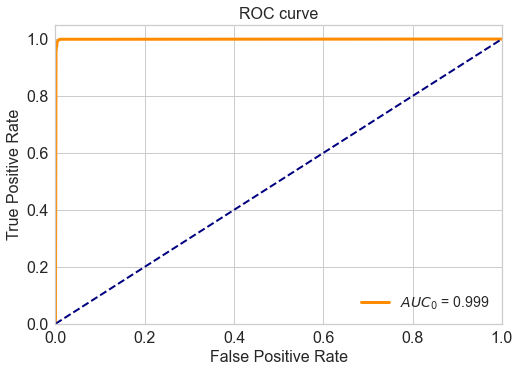

____________________________________
****** VALORE DI AUC *******
0.9988979511819819
____________________________________
****** ROC CURVE: con metodo diretto *******


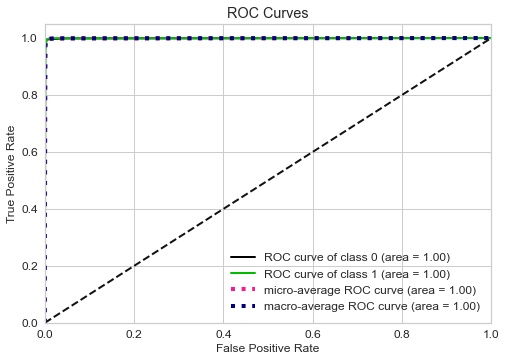

____________________________________
****** Precision recall: con metodo diretto *******


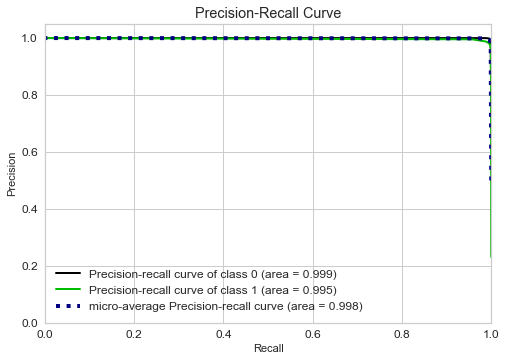

____________________________________
****** Cumulative gain: con metodo diretto *******


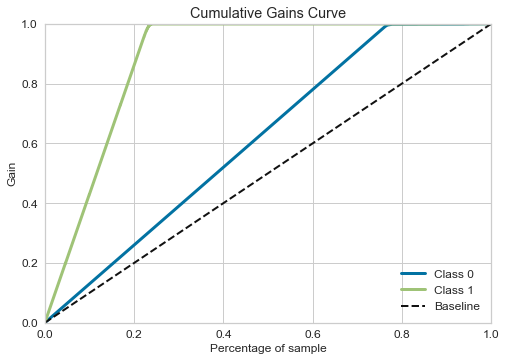

____________________________________
****** Lift curve: con metodo diretto *******


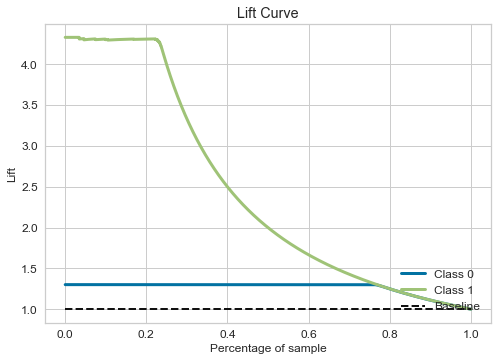

In [255]:
result_pred(y_test, y_pred)
y_score = bb.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

### Explanation - Global Explanation
### Partial Explanation Plot

In [256]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

from skater.core.global_interpretation.partial_dependence import PartialDependence

In [257]:
interpreter = Interpretation(X_train, feature_names=feature_names)

2020-06-11 02:35:08,026 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-11 02:35:09,841 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[28/28] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-11 02:35:11,305 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-11 02:35:12,945 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[12/12] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-11 02:35:13,787 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-11 02:35:15,412 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

2020-06-11 02:35:16,946 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-06-11 02:35:18,668 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 2 seconds

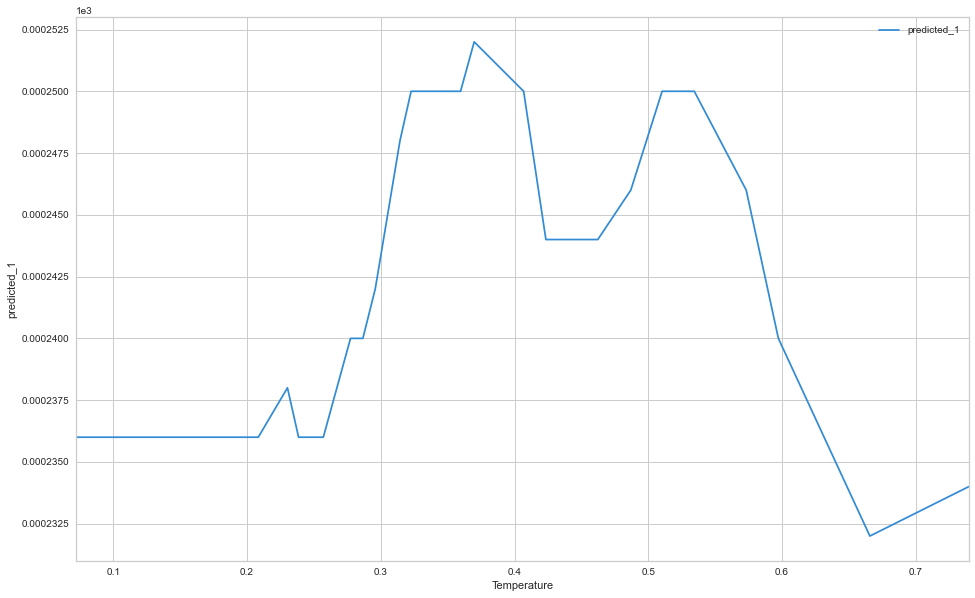

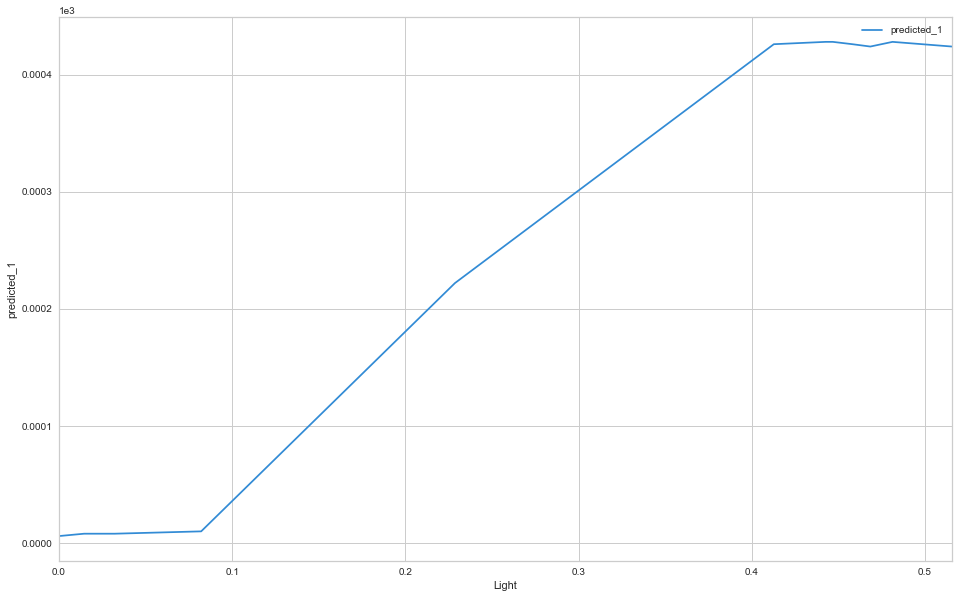

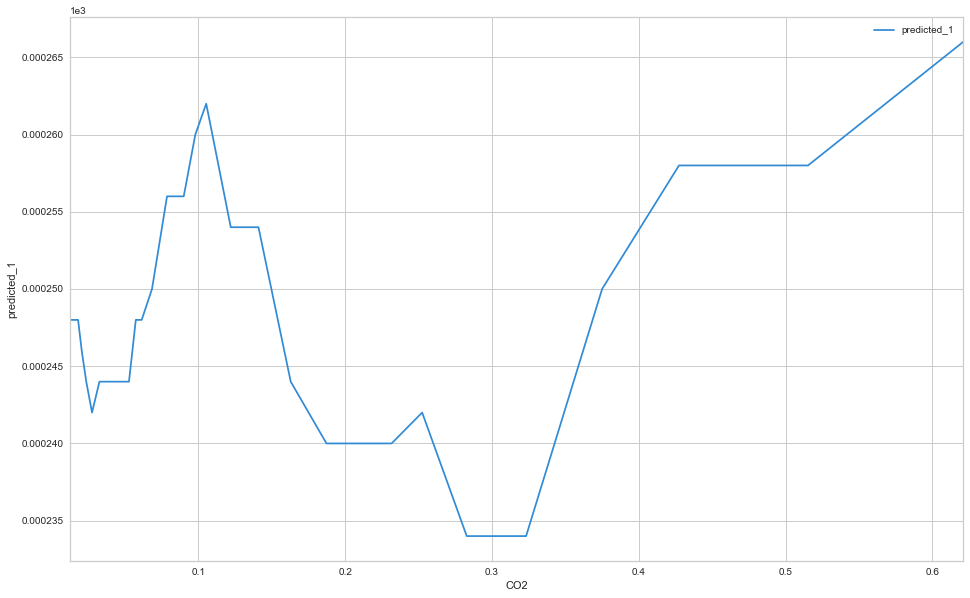

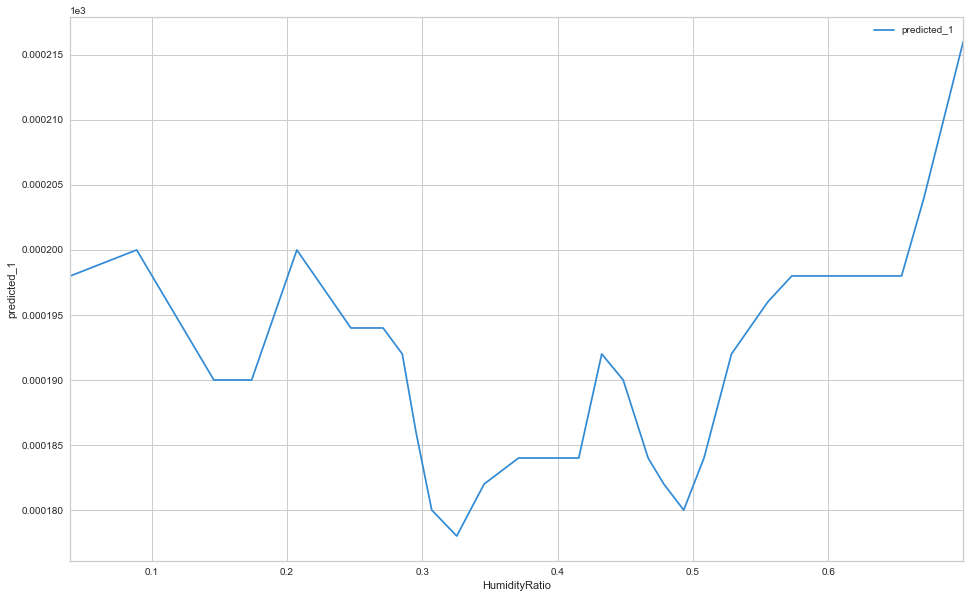

In [258]:
model = InMemoryModel(bb_predict_proba, examples=X_test)
#Facciamo il partial dependence plot rispetto a quelle due features e vediamo come varia la probabilità della classe 1
interpreter.partial_dependence.plot_partial_dependence([feature_names[0], feature_names[1],feature_names[2],feature_names[3]], 
                                                       model, n_samples=100, n_jobs=1)
plt.show()

### Explanation - Local Explanation
### LORE

In [243]:
from lorem import LOREM #Lorem perchè è una collezione di metodi

In [244]:
#Record da testare
i_list=[i for i in range(0, 300, 10)]
#Insieme di valori associati ai record
x_list =[]
for i in i_list:
    x_list.append((X_test[i], i))

In [245]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                   neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                   size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                   verbose=True)

calculating feature values


In [246]:
exp_list = []
for x, i in x_list:
    exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)
    exp_list.append((exp, i))


generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	133   	0.68952 	0.462314	0.993306
2  	129   	0.853246	0.447175	0.993306
3  	128   	0.915306	0.314994	0.993306
4  	132   	0.940505	0.479393	0.993306
5  	126   	0.932116	0.428014	0.993307
6  	134   	0.925122	0.47068 	0.993307
7  	125   	0.897734	0.383747	0.993307
8  	130   	0.93155 	0.469764	0.993307
9  	127   	0.920048	0.4316  	0.993307
10 	126   	0.916912	0.461295	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	127   	0.565177	0.427653	0.992625
2  	119   	0.639312	0.421748	0.992772
3  	128   	0.771769	0.394322	0.992772
4  	131   	0.824084	0.348344	0.992772
5  	130   	0.849833	0.391907	0.992772
6  	134   	0.866395	0.399889	0.992873
7  	128   	0.858675	0.440301	0.992912
8  	133   	0.888869	0.445782	0.992917
9  	129   	0.850307	0.405308	0.992917
10 	135   	0.844059	0.414423	0.992917
synthetic neighborhood class counts {0: 183, 1: 177}
learning local decision tree
r

gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	131   	0.697874	0.484945	0.993307
2  	129   	0.90071 	0.482117	0.993307
3  	128   	0.963158	0.484401	0.993307
4  	126   	0.959591	0.46469 	0.993307
5  	119   	0.95631 	0.443291	0.993307
6  	135   	0.959401	0.481457	0.993307
7  	128   	0.966392	0.478677	0.993307
8  	128   	0.956787	0.485684	0.993307
9  	135   	0.939841	0.459624	0.993307
10 	125   	0.947213	0.460225	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	139   	0.523421	0.463779	0.992781
2  	132   	0.601275	0.450534	0.992781
3  	127   	0.69288 	0.454483	0.992781
4  	127   	0.818548	0.422523	0.992782
5  	124   	0.883005	0.463732	0.992782
6  	135   	0.871142	0.411427	0.992782
7  	133   	0.881966	0.465394	0.992821
8  	129   	0.866759	0.472411	0.992821
9  	122   	0.89052 	0.438061	0.992821
10 	122   	0.899215	0.463429	0.992854
synthetic neighborhood class counts {0: 180, 1: 180}
learning local decision tree
retrieving explanation
generating ne

1  	121   	0.698236	0.495989	0.993307
2  	125   	0.891127	0.461333	0.993306
3  	129   	0.956224	0.483705	0.993307
4  	125   	0.950346	0.46297 	0.993302
5  	134   	0.952687	0.462549	0.993302
6  	126   	0.960937	0.48496 	0.993302
7  	122   	0.947926	0.465738	0.993305
8  	133   	0.977803	0.486419	0.993302
9  	122   	0.963855	0.456397	0.993307
10 	131   	0.951428	0.486281	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	122   	0.53002	0.466702	0.991565
2  	131   	0.566936	0.465518	0.991565
3  	130   	0.675579	0.467507	0.991565
4  	129   	0.786978	0.394909	0.991765
5  	129   	0.842767	0.465841	0.992623
6  	123   	0.867794	0.469876	0.992623
7  	129   	0.860939	0.466959	0.992623
8  	130   	0.874875	0.466992	0.992623
9  	134   	0.857502	0.487746	0.992623
10 	121   	0.880761	0.469235	0.992893
synthetic neighborhood class counts {0: 181, 1: 179}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.4966

2  	128   	0.947332	0.425001	0.993307
3  	136   	0.967608	0.438914	0.993307
4  	127   	0.977867	0.46537 	0.993307
5  	121   	0.971882	0.463255	0.993307
6  	134   	0.975634	0.45736 	0.993307
7  	131   	0.982429	0.451369	0.993307
8  	123   	0.984195	0.462989	0.993307
9  	123   	0.981883	0.470743	0.993307
10 	118   	0.978362	0.461404	0.993307
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	133   	0.501446	0.460979	0.956561
2  	133   	0.523503	0.437988	0.965195
3  	116   	0.561398	0.422514	0.965195
4  	131   	0.588685	0.372384	0.9658  
5  	133   	0.665832	0.384042	0.970453
6  	131   	0.79152 	0.409939	0.970453
7  	124   	0.823231	0.382151	0.97274 
8  	122   	0.828457	0.425384	0.97274 
9  	131   	0.85861 	0.366528	0.970867
10 	128   	0.844603	0.383477	0.970881
synthetic neighborhood class counts {0: 197, 1: 163}
learning local decision tree
retrieving explanation
generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	119   	0.698

In [228]:
for exp, i in exp_list:
    print("Explanation per il record: " + str(i))
    print(exp) #Qua abbiamo l'explanation, la regola e in basse il counter factor 

Explanation per il record: 0
r = { Light <= 0.28, TimeSpan != AF, Temperature > 0.03, CO2 <= 0.47, TimeSpan != EV } --> { Occupancy: 0 }
c = { { Light > 0.33 },
      { Temperature <= 0.03 } }
Explanation per il record: 10
r = { Light <= 0.17 } --> { Occupancy: 0 }
c = { { Light > 0.26 },
      { Light > 0.17 } }
Explanation per il record: 20
r = { Light <= 0.51, TimeSpan = NI } --> { Occupancy: 0 }
c = { { Light > 0.55 },
      { Light > 0.51 } }
Explanation per il record: 30
r = { WeekSpan = WE } --> { Occupancy: 0 }
c =  }
Explanation per il record: 40
r = { Light <= 0.43 } --> { Occupancy: 0 }
c = { { Light > 0.56 } }
Explanation per il record: 50
r = { Light > 0.26, WeekSpan != WE, Temperature <= 0.80 } --> { Occupancy: 1 }
c = { { WeekSpan = WE },
      { Light <= 0.18 } }
Explanation per il record: 60
r = { Light > 0.33, WeekSpan != WE, TimeSpan != NI } --> { Occupancy: 1 }
c = { { Light <= 0.24 },
      { WeekSpan = WE } }
Explanation per il record: 70
r = { Light <= 0.34, Time

### LIME

In [247]:
from lime.lime_tabular import LimeTabularExplainer

In [248]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names,
                                      class_names=[str(v) for v in class_values], discretize_continuous=False)

In [249]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [250]:
exp.local_exp #ottenniamo la lista delle feature e la loro importanza

{1: [(1, 0.1863014893514979),
  (7, -0.06905629119836787),
  (8, 0.040640543137901955),
  (5, 0.027363122767553854),
  (9, -0.026415071555045258),
  (4, 0.025408482983137633),
  (0, 0.020662940135089996),
  (3, 0.020155700932173677),
  (6, 0.007471618576707478),
  (2, 0.003930237277324171)]}

In [251]:
exp.show_in_notebook() #Qua abbiamo una visualizzazione (a destra abbiamo le feature che danno churn, a sinistra quelle
# che danno "not churn")